#### Business Problem:

Overview:
  
* Mercari is the biggest online community supported “Retail   App” in Japan. They are looking to oﬀer pricing suggestions to sellers. Since, sellers are allowed to put any products from New to damaged or bulk of products, this makes it hard for Mercari to oﬀer the price to its seller.   
  
* Product pricing gets even harder like Clothing has strong seasonal pricing trends and is inﬂuenced by brand names, while electronics have prices based on its specs.   
 
* Some product resale value is higher than others with the same specs.   
  
* Using Product Name, Condition, Brand Name, Description, Shipping Status, Mercari needs to oﬀer price to its seller.   
  


### ML Formulation:

* Target is to predict the price of an item.

* Regression algorithm can be used to slove this problem.

### Metric:

* Metric used in this problems is Root Mean Squared Logarithmic Error (RMSLE).

* RMSLE is similar to RMSE but RMSLE works well even if an outlier is present.

* RMSLE prenalizes more when under-estimated rather than over-estimated.   

* RMSLE does not consider the scale of the predicted and actual value, it considers only relative error.

<img src="RMSLE.png" style="height:200px">

In [1]:
import pandas as pd
import numpy as np
import collections
import json
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from num2words import num2words
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

In [2]:
df = pd.read_csv('Dataset/train.tsv', sep='\t', index_col='train_id')

df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
1            Razer BlackWidow Chroma Keyboard                  3   
2                              AVA-VIV Blouse                  1   
3                       Leather Horse Statues                  1   
4                        24K GOLD plated rose                  1   

                                              category_name brand_name  price  \
train_id                                                                        
0                                         Men/Tops/T-shirts        NaN   10.0   
1         Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                               Women/Tops & Blouses/Blouse     Target   10.0   
3                        Home/Home Décor/Home Décor Accents        NaN   35.0   
4                                   Women/Jewelry/Necklaces        NaN   44.0   

          shipping                                   item_description  
train_id                                                               
0                1                                 No description yet  
1                0  This keyboard is in great condition and works ...  
2                1  Adorable top with a hint of lace and a key hol...  
3                1  New with tags. Leather horses. Retail for [rm]...  
4                0          Complete with certificate of authenticity

# * Analysis:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1482535 entries, 0 to 1482534
Data columns (total 7 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   name               1482535 non-null  object 
 1   item_condition_id  1482535 non-null  int64  
 2   category_name      1476208 non-null  object 
 3   brand_name         849853 non-null   object 
 4   price              1482535 non-null  float64
 5   shipping           1482535 non-null  int64  
 6   item_description   1482531 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 90.5+ MB


In [4]:
df.describe()

item_condition_id         price      shipping
count       1.482535e+06  1.482535e+06  1.482535e+06
mean        1.907380e+00  2.673752e+01  4.472744e-01
std         9.031586e-01  3.858607e+01  4.972124e-01
min         1.000000e+00  0.000000e+00  0.000000e+00
25%         1.000000e+00  1.000000e+01  0.000000e+00
50%         2.000000e+00  1.700000e+01  0.000000e+00
75%         3.000000e+00  2.900000e+01  1.000000e+00
max         5.000000e+00  2.009000e+03  1.000000e+00

### * Price (Target Variable) Analysis:

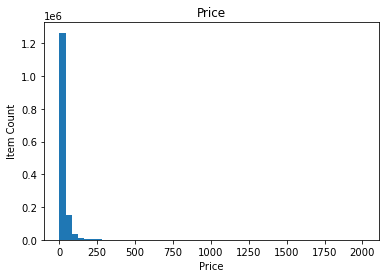

In [5]:
plt.hist(list(df['price']), bins=50)
plt.xlabel('Price')
plt.ylabel('Item Count')
plt.title('Price')
plt.show()

Here distribution of "Price" is right skewd.

In [6]:
df.loc[df['price'] == 0]

name  item_condition_id  \
train_id                                                            
1325      Alabama Crimson Tide Quality Lanyard                  1   
2544                             Levi leggings                  3   
2712              Simple Red Lace Lingerie Top                  3   
3576          Turquoise 15 Pc Makeup Brush Set                  1   
3761                            Girls size 7/8                  3   
...                                        ...                ...   
1474172         Homecoming or Dama ivory dress                  2   
1474198                     Tie up flannel top                  3   
1477958                Rae Dunn Measuring Pear                  3   
1478519       4 pairs women's wool boots socks                  1   
1478813        New Braven HD Waterprf Wireless                  1   

                                              category_name brand_name  price  \
train_id                                                                        
1325                        Sports & Outdoors/Fan Shop/NCAA        NaN    0.0   
2544                               Women/Jeans/Slim, Skinny    Levi's®    0.0   
2712                     Women/Underwear/G-Strings & Thongs        NaN    0.0   
3576      Beauty/Tools & Accessories/Makeup Brushes & Tools        NaN    0.0   
3761                        Kids/Girls (4+)/Tops & T-Shirts        NaN    0.0   
...                                                     ...        ...    ...   
1474172                      Women/Dresses/Above Knee, Mini        NaN    0.0   
1474198                         Women/Tops & Blouses/Blouse        NaN    0.0   
1477958                  Home/Home Décor/Home Décor Accents        NaN    0.0   
1478519                                   Women/Shoes/Boots        NaN    0.0   
1478813   Electronics/TV, Audio & Surveillance/Home Spea...        NaN    0.0   

          shipping                                   item_description  
train_id                                                               
1325             1  TOP QUALITY THICK LANYARD Reversible sides wit...  
2544             0  Light wash. Hardly worn. Size 24 but fits like...  
2712             0  Very simple but cute, a little form fitting as...  
3576             1                                            1 left!  
3761             1  5 pair gap jean excellent used condition 3 chi...  
...            ...                                                ...  
1474172          0  Ivory formal dress. I wore this dress once for...  
1474198          1  I got this last year and just didnt wear it mu...  
1477958          0  The dash lid appears it was dropped and a piec...  
1478519          1  ✔️SHARE YOUR SOCKS WITH FRIENDS AND FAMILY! ✔️...  
1478813          0  The BRV-1 gives action sports and outdoor enth...  

[874 rows x 7 columns]

874 items are missing its price information.

In [7]:
(874/ len(df)) * 100

0.05895307699312327

It accounts for 0.05 percentage of data. So we can remove these data.

In [8]:
df.drop(df[df['price'] == 0].index, inplace = True)

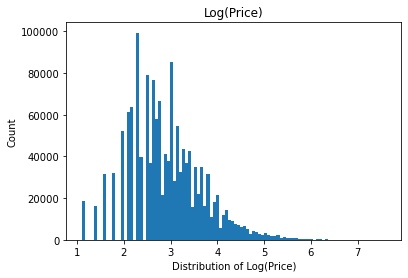

In [9]:
log = np.log(list(df['price']))

plt.hist(log, bins=100)
plt.xlabel('Distribution of Log(Price)')
plt.ylabel('Count')
plt.title('Log(Price)')
plt.show()

After taking Log for Price, its distribution become Gussian/Normal distribution. Hence it is RMSLE is used instead of RMSE

In [10]:
df['log_price'] = np.log(list(df['price']))
df.head()

name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
1            Razer BlackWidow Chroma Keyboard                  3   
2                              AVA-VIV Blouse                  1   
3                       Leather Horse Statues                  1   
4                        24K GOLD plated rose                  1   

                                              category_name brand_name  price  \
train_id                                                                        
0                                         Men/Tops/T-shirts        NaN   10.0   
1         Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                               Women/Tops & Blouses/Blouse     Target   10.0   
3                        Home/Home Décor/Home Décor Accents        NaN   35.0   
4                                   Women/Jewelry/Necklaces        NaN   44.0   

          shipping                                   item_description  \
train_id                                                                
0                1                                 No description yet   
1                0  This keyboard is in great condition and works ...   
2                1  Adorable top with a hint of lace and a key hol...   
3                1  New with tags. Leather horses. Retail for [rm]...   
4                0          Complete with certificate of authenticity   

          log_price  
train_id             
0          2.302585  
1          3.951244  
2          2.302585  
3          3.555348  
4          3.784190

Text(0.5, 0, 'Price Distribution')

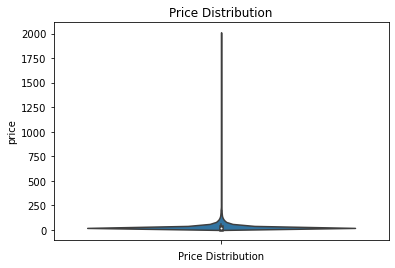

In [11]:
sns.violinplot(y=df['price']).set_title('Price Distribution')
plt.xlabel('Price Distribution')

Most of the product's price falls under 250 USD with outlier's presence.

Text(0.5, 0, 'Price Distribution')

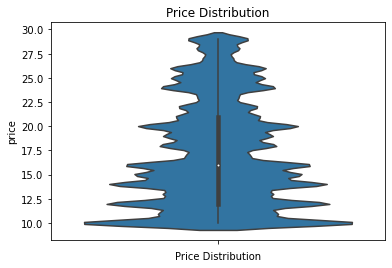

In [12]:
sns.violinplot(y=df.loc[((df['price']>=10) & (df['price']<=29)), 'price']).set_title('Price Distribution')
plt.xlabel('Price Distribution')

Plot Without outliers presence, mean price is around 16$.

In [13]:
df['price'].describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

75% of products price is less that 30 USD but we cannot simply ignore rest of the products (i.e. product price > 30 USD) because, it may heavily dependent on Brand and its type.

### * Item Condition Analysis:

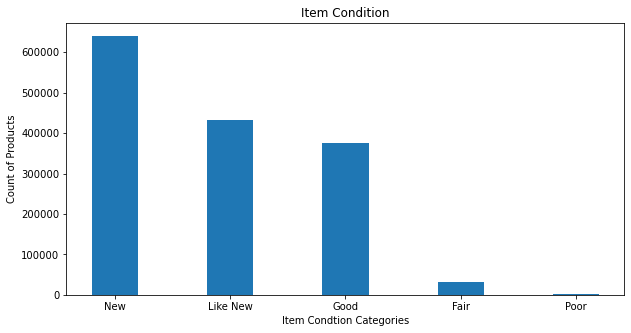

In [14]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['New', 'Like New', 'Good', 'Fair', 'Poor'], list(df['item_condition_id'].value_counts()),  
        width = 0.4)
plt.ylabel('Count of Products')
plt.xlabel('Item Condtion Categories')
plt.title('Item Condition')
plt.show()

In [15]:
(640549+432161+375479)/1482535 * 100

97.68329246864323

97% of the product listed in Mercari are in good conditions (i.e. New, Like New & Good).  

In [16]:
np.unique(df['item_condition_id'].isna())

array([False])

item_condition_id have no missing data.

### * Shipping Analysis:

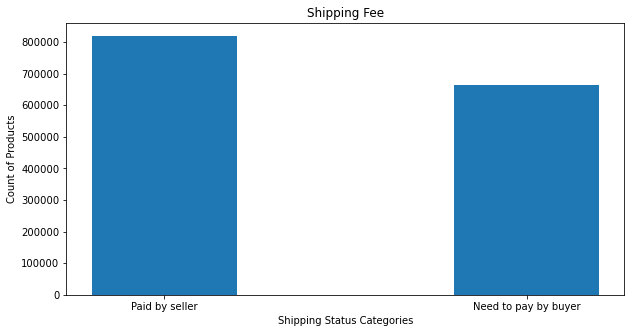

In [17]:
fig = plt.figure(figsize = (10, 5))
plt.bar(['Paid by seller', 'Need to pay by buyer'], list(df['shipping'].value_counts()),  
        width = 0.4)
plt.ylabel('Count of Products')
plt.xlabel('Shipping Status Categories')
plt.title('Shipping Fee')
plt.show()

* 55% products shipping fees are paid by seller.
* 45% products shipping fees need to pay by buyer.

In [18]:
np.unique(df['shipping'].isna())

array([False])

Shipping has no missing data.

In [19]:
print(len(df.loc[df['shipping']==1]))
print(len(df.loc[df['shipping']==0]))

662785
818876


In [20]:
(819435/(819435+663100)) * 100

55.272556803043436

55% of products shipping price has to be paid by the user.

### * Brand Analysis:

In [21]:
df['brand_name'].value_counts()

PINK                         54072
Nike                         54006
Victoria's Secret            48011
LuLaRoe                      30995
Apple                        17314
                             ...  
Educational Insights             1
Simple                           1
Holden                           1
United Colors Of Benetton        1
Mayoral                          1
Name: brand_name, Length: 4807, dtype: int64

There are 4809 brands are listed.

In [22]:
df.loc[df['brand_name'].isna()==True, 'brand_name']

train_id
0          NaN
3          NaN
4          NaN
5          NaN
9          NaN
          ... 
1482526    NaN
1482527    NaN
1482532    NaN
1482533    NaN
1482534    NaN
Name: brand_name, Length: 632336, dtype: object

In [23]:
(632682/1482535) * 100

42.675687251902986

There are 42% of data is missing.

In [24]:
df['brand_name'].value_counts()

PINK                         54072
Nike                         54006
Victoria's Secret            48011
LuLaRoe                      30995
Apple                        17314
                             ...  
Educational Insights             1
Simple                           1
Holden                           1
United Colors Of Benetton        1
Mayoral                          1
Name: brand_name, Length: 4807, dtype: int64

In [25]:
np.cumsum(list(df['brand_name'].value_counts()))

array([ 54072, 108078, 156089, ..., 849323, 849324, 849325], dtype=int32)

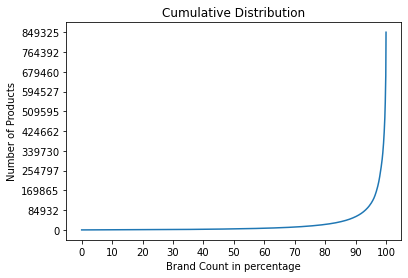

In [26]:
br = list(df['brand_name'].value_counts())
br.sort(reverse=False)

l = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

x = range(0, 4807)
y = np.cumsum(br)
plt.plot(x, y)
plt.xticks([int((4807 * (i/100))) for i in l], [item for item in l])
plt.xlabel('Brand Count in percentage')
plt.yticks([int((y[len(y)-1] * (i/100))) for i in l])
plt.ylabel('Number of Products')
plt.title('Cumulative Distribution')
plt.show()

The above plot shows us that, approximately 90% of products are composed only of 10% of Brands. 

In [27]:
ten_percent = df['brand_name'].value_counts()[:480].sum()
tot_products = df['brand_name'].value_counts().sum()

print('10% of brands composes of', int((ten_percent/tot_products) * 100), 'percentage of products.')

10% of brands composes of 93 percentage of products.


### * Category Name Analysis:

In [28]:
df['category_name']

train_id
0                                          Men/Tops/T-shirts
1          Electronics/Computers & Tablets/Components & P...
2                                Women/Tops & Blouses/Blouse
3                         Home/Home Décor/Home Décor Accents
4                                    Women/Jewelry/Necklaces
                                 ...                        
1482530                               Women/Dresses/Mid-Calf
1482531                             Kids/Girls 2T-5T/Dresses
1482532       Sports & Outdoors/Exercise/Fitness accessories
1482533                   Home/Home Décor/Home Décor Accents
1482534                    Women/Women's Accessories/Wallets
Name: category_name, Length: 1481661, dtype: object

There are three levels of categories present.

In [29]:
np.unique(df['category_name'].isna(), return_counts=True)

(array([False,  True]), array([1475347,    6314], dtype=int64))

In [30]:
(6327 / (1476208+6327)) * 100

0.42676901388500105

Only 4 percentage of datas are missing

In [31]:
cate_list = list(df['category_name'].dropna().str.split('/'))

In [32]:
level_1 = []
level_2 = []
level_3 = []

for i in cate_list:
    level_1.append(i[0])
    level_2.append(i[1])
    level_3.append(i[2])

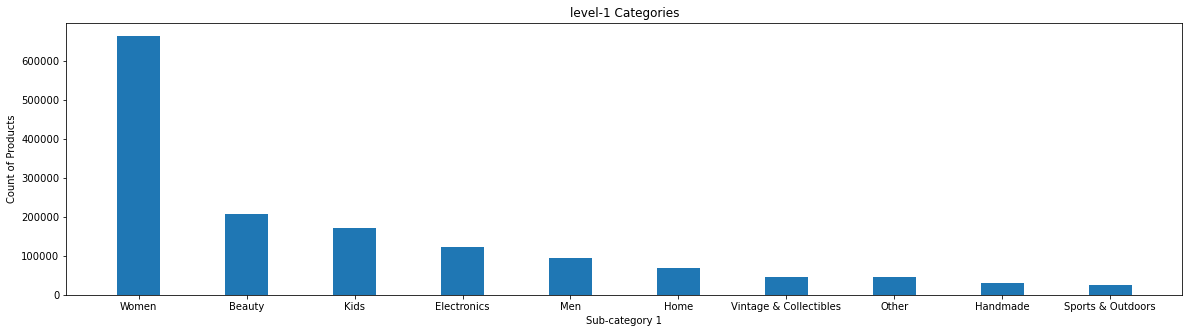

In [33]:
keys = np.unique(level_1, return_counts=True)[0]
values = np.unique(level_1, return_counts=True)[1]

level_1_map = {}
for i in range(len(keys)):
    level_1_map[keys[i]] = values[i]
    
sorted_level_1_map = sorted(level_1_map.items(), key=lambda x:x[1], reverse=True)

fig = plt.figure(figsize = (20, 5))
plt.bar([sorted_level_1_map[i][0] for i in range(10)], [sorted_level_1_map[i][1] for i in range(10)],  
        width = 0.4)
plt.ylabel('Count of Products')
plt.xlabel('Sub-category 1')
plt.title('level-1 Categories')
plt.show()

In Level-1, women's products has listed in greater number than others. 

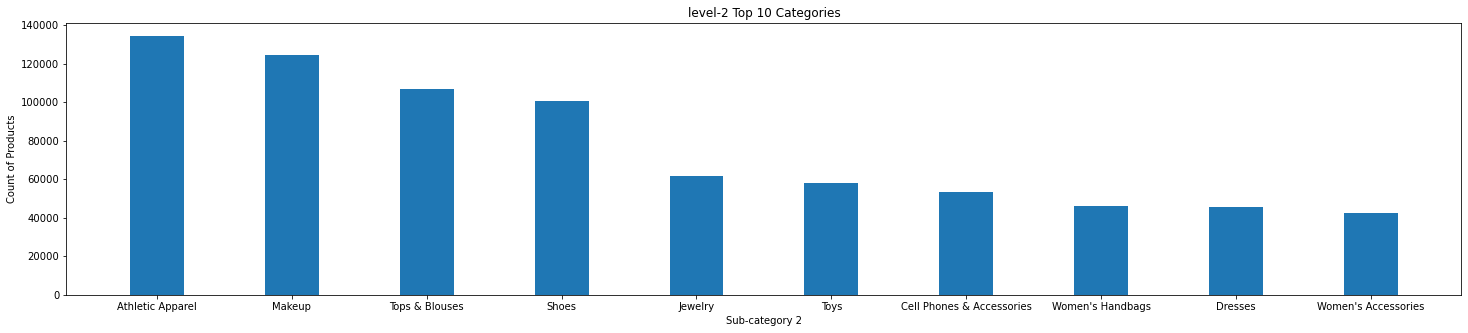

In [34]:
keys = np.unique(level_2, return_counts=True)[0]
values = np.unique(level_2, return_counts=True)[1]

level_2_map = {}
for i in range(len(keys)):
    level_2_map[keys[i]] = values[i]
    
sorted_level_2_map = sorted(level_2_map.items(), key=lambda x:x[1], reverse=True)

fig = plt.figure(figsize = (25, 5))
plt.bar([sorted_level_2_map[i][0] for i in range(10)], [sorted_level_2_map[i][1] for i in range(10)],  
        width = 0.4)
plt.ylabel('Count of Products')
plt.xlabel('Sub-category 2')
plt.title('level-2 Top 10 Categories')
plt.show()

In Level-2, Athletic Apparel, Makeup, Tops & Blouses are listed top 3 categories. We can see that clothing products have listed in higher number.

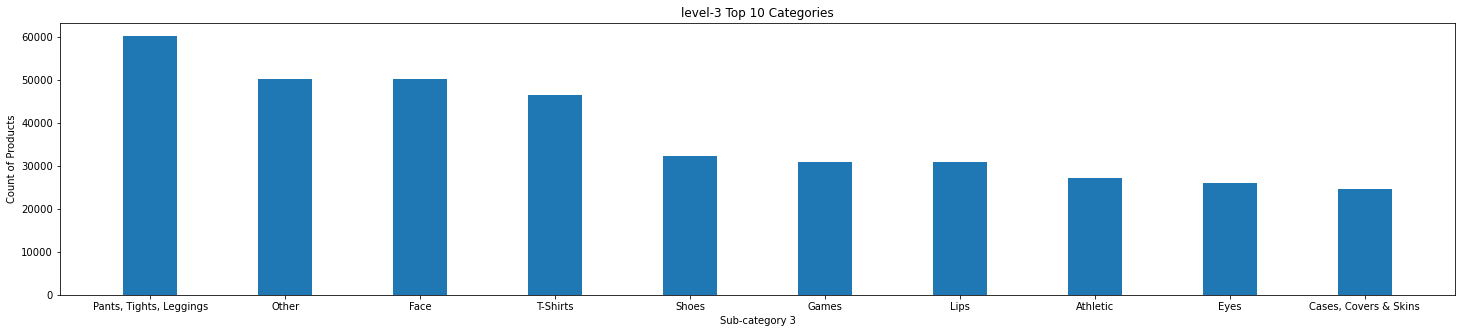

In [35]:
keys = np.unique(level_3, return_counts=True)[0]
values = np.unique(level_3, return_counts=True)[1]

level_3_map = {}
for i in range(len(keys)):
    level_3_map[keys[i]] = values[i]
    
sorted_level_3_map = sorted(level_3_map.items(), key=lambda x:x[1], reverse=True)

fig = plt.figure(figsize = (25, 5))
plt.bar([sorted_level_3_map[i][0] for i in range(10)], [sorted_level_3_map[i][1] for i in range(10)],  
        width = 0.4)
plt.ylabel('Count of Products')
plt.xlabel('Sub-category 3')
plt.title('level-3 Top 10 Categories')
plt.show()

In Level-3, confirms that clothing products have listed in higher number.

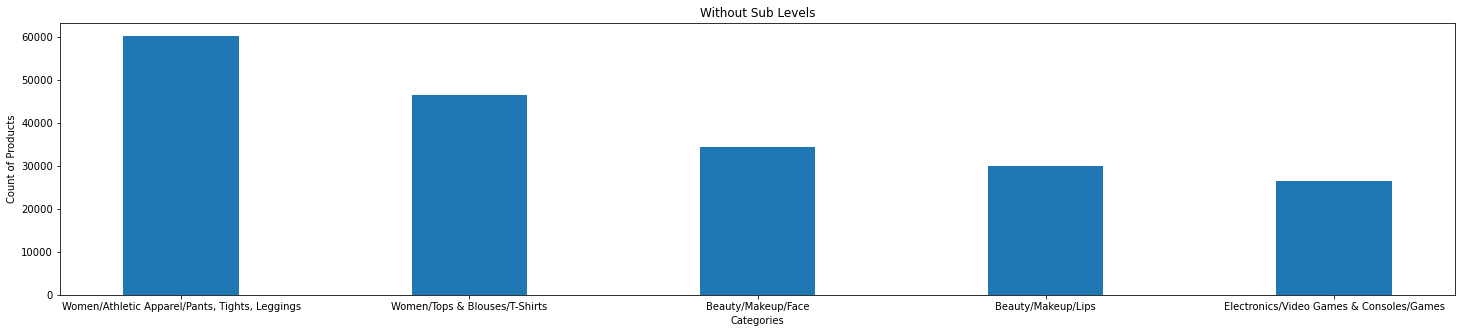

In [36]:
keys = np.unique(df['category_name'].dropna(), return_counts=True)[0]
values = np.unique(df['category_name'].dropna(), return_counts=True)[1]

without_level = {}
for i in range(len(keys)):
    without_level[keys[i]] = values[i]
    
sorted_without_level = sorted(without_level.items(), key=lambda x:x[1], reverse=True)

fig = plt.figure(figsize = (25, 5))
plt.bar([sorted_without_level[i][0] for i in range(5)], [sorted_without_level[i][1] for i in range(5)],  
        width = 0.4)
plt.ylabel('Count of Products')
plt.xlabel('Categories')
plt.title('Without Sub Levels')
plt.show()

Above plot shows that Womens clothing and beauty products are listed in higher numbers.

### * Product Name Analysis:

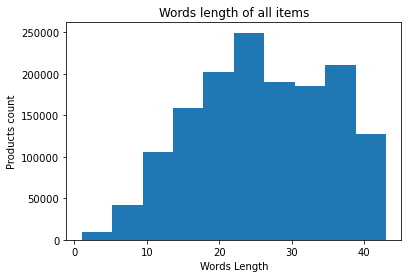

In [37]:
plt.hist(df['name'].str.len())
plt.xlabel('Words Length')
plt.ylabel('Products count')
plt.title('Words length of all items')
plt.show()

Text(0.5, 0, 'Distribution of Product name count')

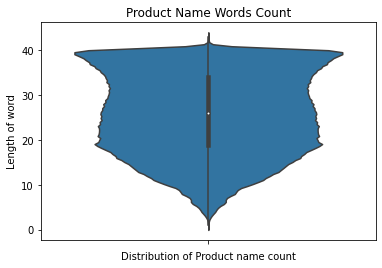

In [38]:
sns.violinplot(y=df['name'].str.len()).set_title('Product Name Words Count')
plt.ylabel('Length of word')
plt.xlabel('Distribution of Product name count')

We can see that average words of Product name is around 25.

In [39]:
np.unique(df['name'].isna(), return_counts=True)

(array([False]), array([1481661], dtype=int64))

Here there is no missing data.

In [40]:
# Reference: https://www.geeksforgeeks.org/generating-word-cloud-python/

stopwords = set(STOPWORDS)

product_names = ' '.join(df['name'].str.lower())

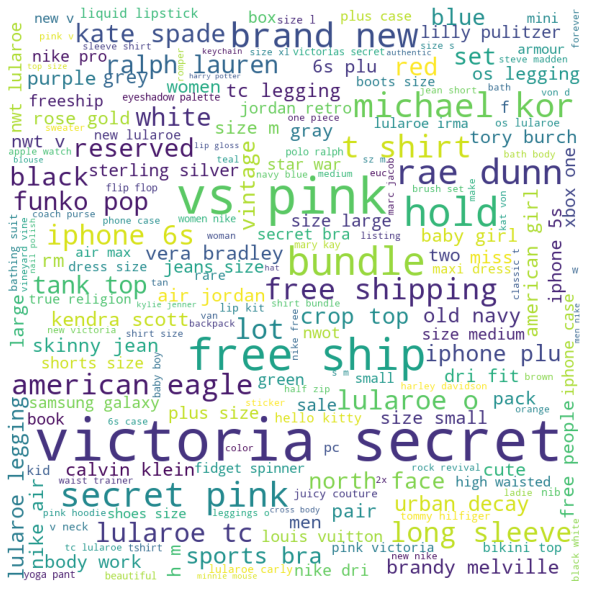

In [41]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(product_names)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* Top brands are frequently listed, which is also confirmed in Brand Analysis. 
* Black color products are listed in large number.
* Gender specifiction is also present in the product name.
* Bundle of items is also spedicied.

### * Product Description Analysis:

Text(0.5, 0, 'Distribution of Product Description count')

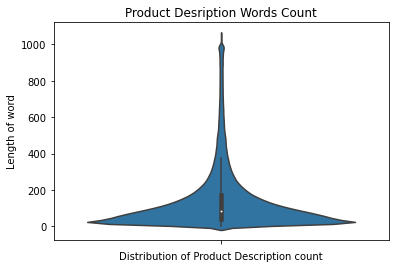

In [42]:
sns.violinplot(y=df['item_description'].str.len()).set_title('Product Desription Words Count')
plt.ylabel('Length of word')
plt.xlabel('Distribution of Product Description count')

In [43]:
np.mean(df['item_description'].str.len())

145.71879929025408

We can see that average words of Product description is around 145.

In [44]:
np.unique(df['item_description'].isna(), return_counts=True)

(array([False,  True]), array([1481657,       4], dtype=int64))

In [45]:
np.unique(df['item_description'] == 'No description yet', return_counts=True)

(array([False,  True]), array([1399234,   82427], dtype=int64))

In [46]:
(82489/(1400046+82489)) * 100

5.564050764400165

5% of description is not present.

In [47]:
update_desc = df.loc[df['item_description'] != 'No description yet', 'item_description']

In [48]:
update_desc = update_desc.dropna()
print(np.unique(update_desc.isna(), return_counts=True))
update_desc = list(update_desc)

(array([False]), array([1399230], dtype=int64))


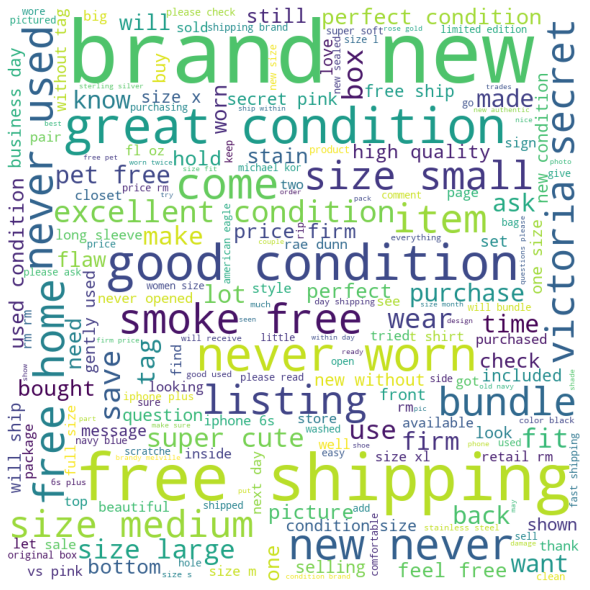

In [49]:
# Reference: https://www.geeksforgeeks.org/generating-word-cloud-python/

product_desc = ' '.join(update_desc).lower()

wordcloud_desc = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(product_desc)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_desc) 
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

* Most of the Description talks about Product's condition. 
* It also talks about shipping status.
* Some of them talks about Product's properties like size, color etc,.
* Bundle details also mentioned in descriptions.  

### * Item Condition Vs Price:

In [50]:
analysis_data = df.loc[((df['price']>=10) & (df['price']<=29))].copy()
analysis_data.head(2)

name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
2                              AVA-VIV Blouse                  1   

                        category_name brand_name  price  shipping  \
train_id                                                            
0                   Men/Tops/T-shirts        NaN   10.0         1   
2         Women/Tops & Blouses/Blouse     Target   10.0         1   

                                           item_description  log_price  
train_id                                                                
0                                        No description yet   2.302585  
2         Adorable top with a hint of lace and a key hol...   2.302585

Text(0.5, 1.0, 'Item Condition Vs Price')

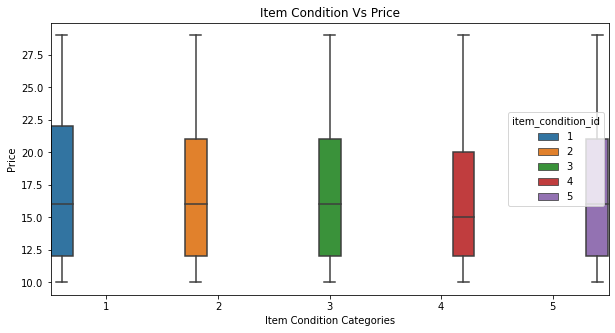

In [51]:
plt.figure(figsize=(10, 5))
sns.boxplot(x = "item_condition_id", y = "price", hue = "item_condition_id", data=analysis_data, width=1)
plt.xlabel('Item Condition Categories')
plt.ylabel('Price')
plt.title('Item Condition Vs Price')

* The above plot shows that item_condition-5 (poor) and item_condition-3 (Good) mean price is greater than item_condition-1 (New), but mean price item_condition-1 should be greater than both of them since it a new product.
* Outlier might be reason for above factor.

In [52]:
print(np.median(df.loc[df['item_condition_id'] == 1, 'price']))
print(np.median(df.loc[df['item_condition_id'] == 1, 'log_price']))

18.0
2.8903717578961645


In [53]:
print(np.median(df.loc[df['item_condition_id'] == 3, 'price']))
print(np.median(df.loc[df['item_condition_id'] == 3, 'log_price']))

16.0
2.772588722239781


In [54]:
print(np.median(df.loc[df['item_condition_id'] == 5, 'price']))
print(np.median(df.loc[df['item_condition_id'] == 5, 'log_price']))

19.0
2.9444389791664403


* By checking the median price we see that item_condition-1 is greater than item_condition-3.
* But median price item_condition-5 still greater than item_condition-1. Some other factors might be reason for this.

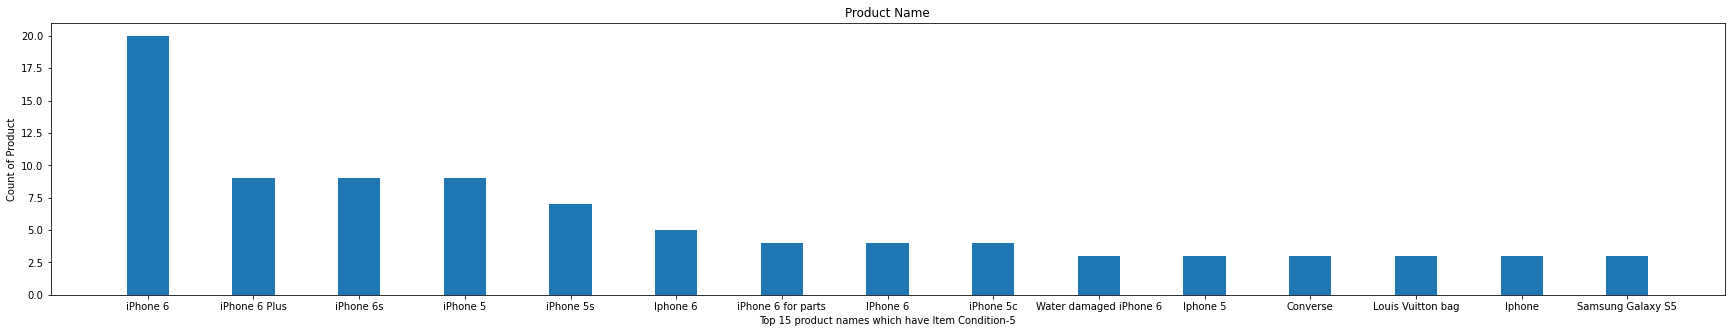

In [55]:
keys = df.loc[df['item_condition_id'] == 5, ['name']].value_counts().reset_index()['name'][:15]
values = list(df.loc[df['item_condition_id'] == 5, ['name']].value_counts()[:15])

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys), list(df.loc[df['item_condition_id'] == 5, ['name']].value_counts()[:15]),  
        width = 0.4)
plt.xlabel('Top 15 product names which have Item Condition-5')
plt.ylabel('Count of Product')
plt.title('Product Name')
plt.show()

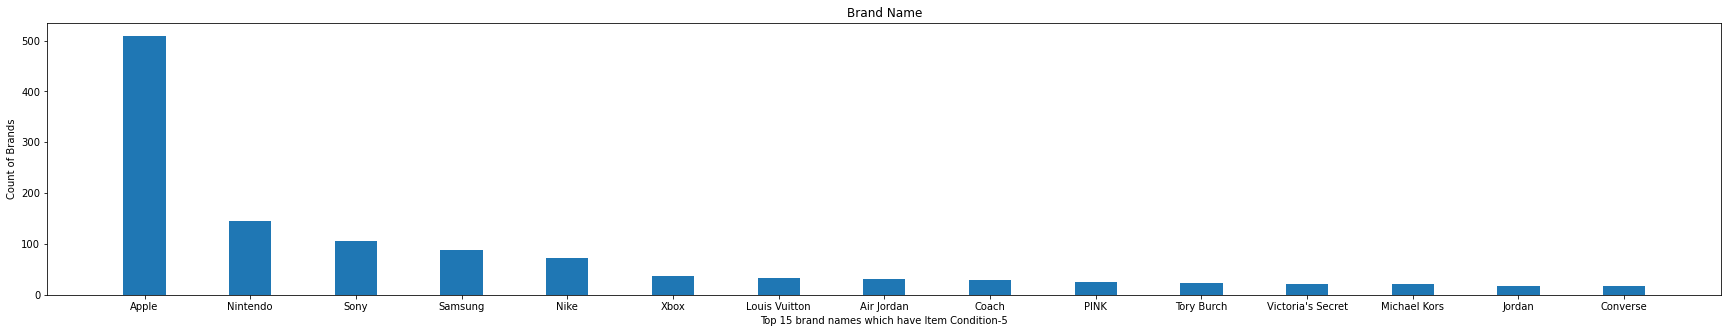

In [56]:
keys = df.loc[df['item_condition_id'] == 5, ['brand_name']].value_counts().reset_index()['brand_name'][:15]
values = list(df.loc[df['item_condition_id'] == 5, ['brand_name']].value_counts()[:15])

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys), list(df.loc[df['item_condition_id'] == 5, ['brand_name']].value_counts()[:15]),  
        width = 0.4)
plt.xlabel('Top 15 brand names which have Item Condition-5')
plt.ylabel('Count of Brands')
plt.title('Brand Name')
plt.show()

In [57]:
# Reference: https://www.geeksforgeeks.org/generating-word-cloud-python/

item_cond_product_names = '' 

data = df.loc[df['item_condition_id'] == 5, 'name'].dropna().str.lower()

item_cond_product_names = ' '.join(data)

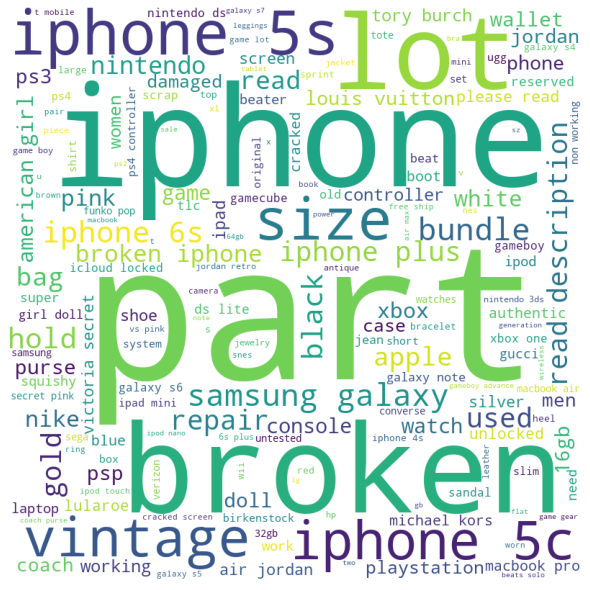

In [58]:
wordcloud_item_cond_product_names = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(item_cond_product_names)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_item_cond_product_names) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* Reasons for mean price of item_condition-5 greater than item_condition-1 are
    * Product brand, since people buy top brands products even if it is damaged.
    * Its mostly consist of electornic items like iphone, xbox, etc,.
    * Some vintage collection items.

In [59]:
# Reference: https://www.geeksforgeeks.org/generating-word-cloud-python/

item_cond_product_names = '' 

data = df.loc[df['item_condition_id'] == 1, 'name'].dropna().str.lower()

item_cond_product_names = ' '.join(data)

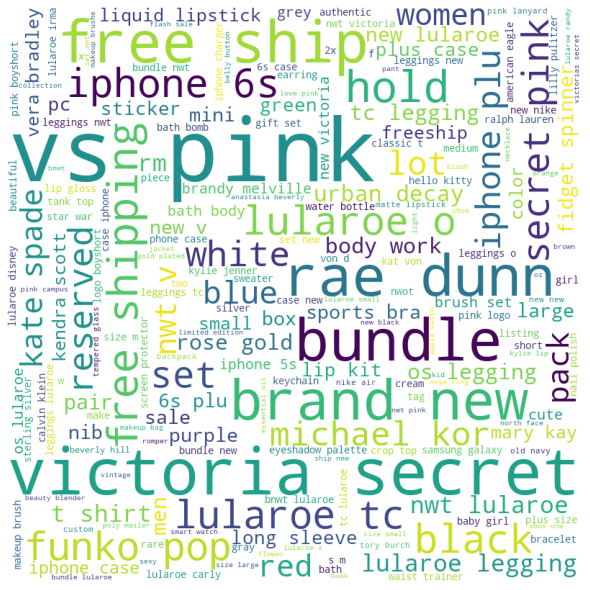

In [60]:
wordcloud_item_cond_product_names = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(item_cond_product_names)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_item_cond_product_names) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

### * Shipping Vs Price:

<AxesSubplot:title={'center':'Shipping Vs Price'}, xlabel='shipping', ylabel='price'>

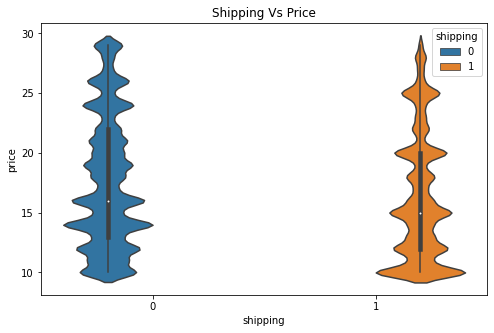

In [61]:
plt.figure(figsize=(8, 5))
plt.title('Shipping Vs Price')
sns.violinplot(x='shipping', y='price', hue='shipping', data=analysis_data)

In [62]:
df.loc[df['shipping']==1, 'price'].describe()

count    662785.000000
mean         22.578452
std          36.961295
min           3.000000
25%           9.000000
50%          14.000000
75%          25.000000
max        2000.000000
Name: price, dtype: float64

In [63]:
df.loc[df['shipping']==0, 'price'].describe()

count    818876.000000
mean         30.132333
std          39.541581
min           5.500000
25%          13.000000
50%          20.000000
75%          33.000000
max        2009.000000
Name: price, dtype: float64

* The above statistics shows that Shipping Status '0' mean price is higher than Shipping Status '1'.
* This factor is surprising, the price of product which has Shipping status '1' should be higher, since shipping price is paid by the seller. 

In [64]:
df.loc[df['shipping']==0, 'brand_name'].dropna().value_counts()

Nike                   38763
PINK                   34335
Victoria's Secret      29296
LuLaRoe                14305
Rae Dunn               11935
                       ...  
Uglydoll                   1
Peugeot                    1
Cruiser Accessories        1
NY Jeans                   1
Ujena                      1
Name: brand_name, Length: 4261, dtype: int64

In [65]:
df.loc[df['shipping']==1, 'brand_name'].dropna().value_counts()

PINK                 19737
Victoria's Secret    18715
LuLaRoe              16690
Nike                 15243
Apple                 9120
                     ...  
Structure                1
FAO Schwarz              1
Chevron®                 1
Floppy Products          1
timi & leslie            1
Name: brand_name, Length: 3505, dtype: int64

The above stats shows that more branded products are listed in "Shipping Status 0" than "Shipping Status 1", this might be one of the reason for higher mean price in Shipping Status 0.

### * Brand Name Vs Price:

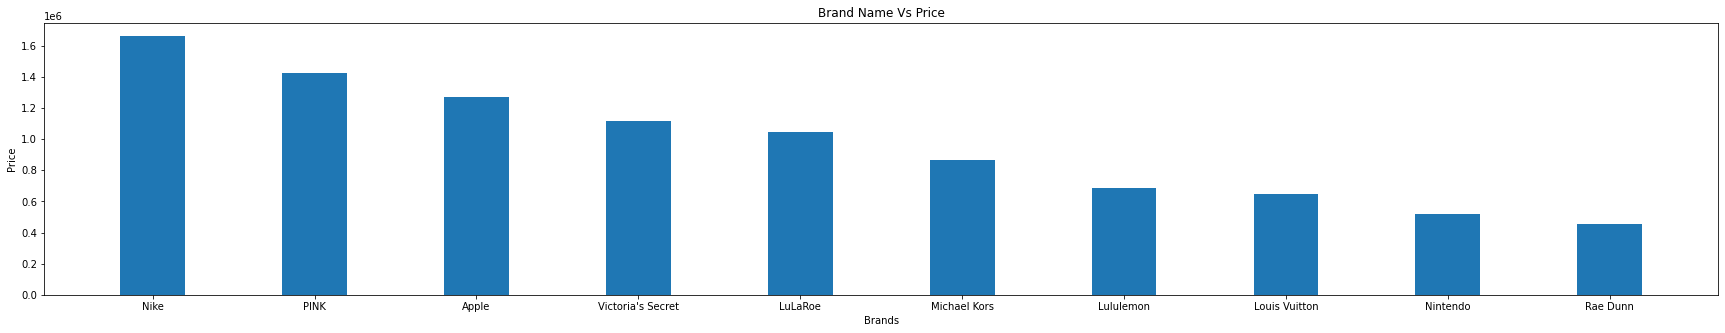

In [66]:
keys = df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']
values = df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:10]), list(values[:10]), width = 0.4)
plt.title('Brand Name Vs Price')
plt.ylabel('Price')
plt.xlabel('Brands')
plt.show()

Above ate top 10 brands are listed more in the order of summed price.

Text(0.5, 0, 'Top 10 brand name which have higher summed price')

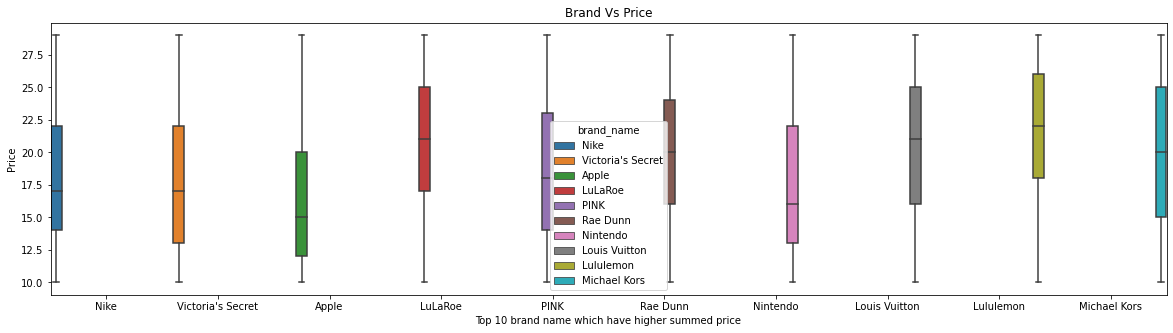

In [67]:
plt.figure(figsize=(20, 5))
plt.title('Brand Vs Price')
sns.boxplot(x = "brand_name", y = "price", hue = "brand_name", data=analysis_data.loc[analysis_data['brand_name'].isin(list(keys[:10]))], width=1)
plt.ylabel('Price')
plt.xlabel('Top 10 brand name which have higher summed price')

Here price of "Louis Vuitton" products are higher when compared to other top brands. 

### * Category Vs Price:

In [68]:
cate_data = analysis_data.loc[:, ['category_name', 'price']].dropna().reset_index()
cate_data.drop('train_id', axis=1, inplace=True)
cate_data.head()

category_name  price
0                Men/Tops/T-shirts   10.0
1      Women/Tops & Blouses/Blouse   10.0
2  Sports & Outdoors/Apparel/Girls   19.0
3   Women/Dresses/Above Knee, Mini   16.0
4        Beauty/Makeup/Makeup Sets   11.0

In [69]:
level_1 = []
level_2 = []
level_3 = []

cate_list = cate_data['category_name'].str.split('/')

for i in cate_list:
    level_1.append(i[0])
    level_2.append(i[1])
    level_3.append(i[2])
    
sub_l1 = pd.Series(level_1)
sub_l2 = pd.Series(level_2)
sub_l3 = pd.Series(level_3)

In [70]:
cate_data.drop(columns=['category_name'], inplace=True)

In [71]:
cate_data['sub_l1'] = sub_l1
cate_data['sub_l2'] = sub_l2
cate_data['sub_l3'] = sub_l3

In [72]:
cate_data.head()

price             sub_l1          sub_l2            sub_l3
0   10.0                Men            Tops          T-shirts
1   10.0              Women  Tops & Blouses            Blouse
2   19.0  Sports & Outdoors         Apparel             Girls
3   16.0              Women         Dresses  Above Knee, Mini
4   11.0             Beauty          Makeup       Makeup Sets

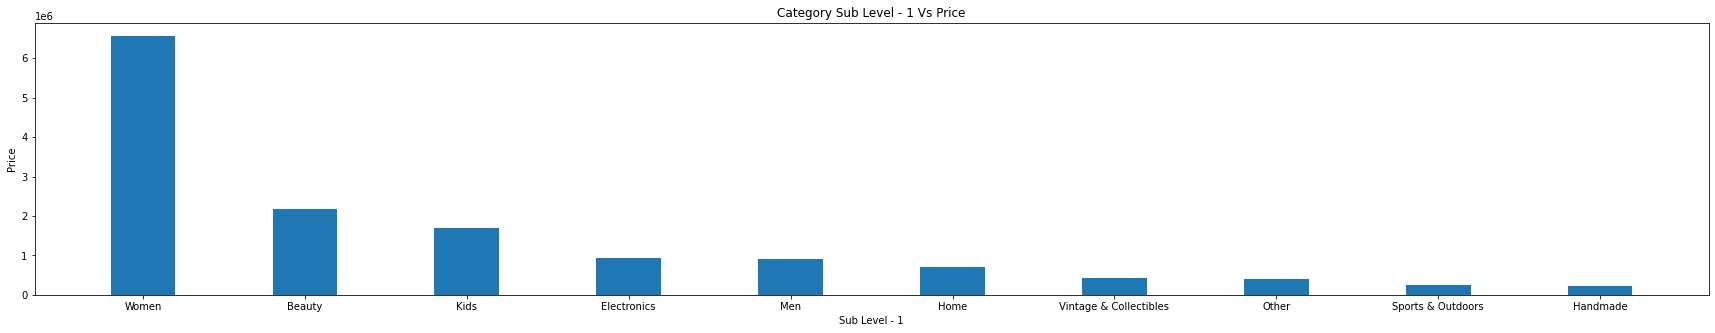

In [73]:
keys = cate_data.groupby(['sub_l1'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_l1']
values = cate_data.groupby(['sub_l1'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:10]), list(values[:10]), width = 0.4)
plt.title('Category Sub Level - 1 Vs Price')
plt.ylabel('Price')
plt.xlabel('Sub Level - 1')
plt.show()

* Since womens products are listed higher in number, so total price of all womens product is higher than other. 

Text(0.5, 0, 'Sub Level - 1')

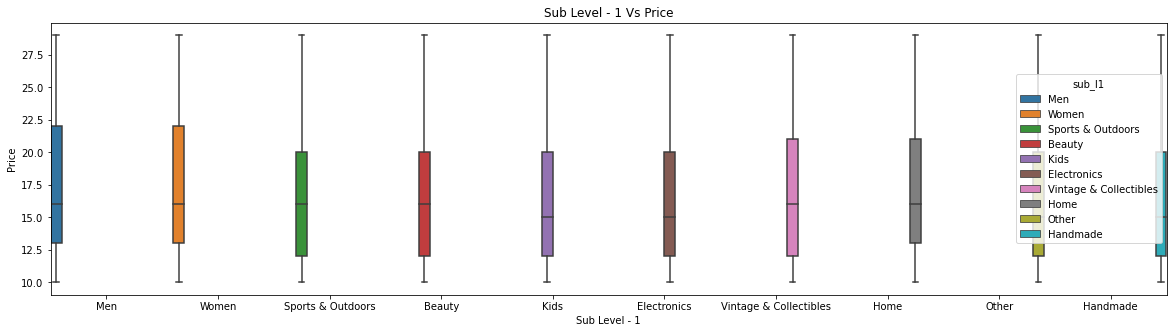

In [74]:
plt.figure(figsize=(20, 5))
plt.title('Sub Level - 1 Vs Price')
sns.boxplot(x = "sub_l1", y = "price", hue = "sub_l1", data=cate_data, width=1)
plt.ylabel('Price')
plt.xlabel('Sub Level - 1')

In [75]:
cate_data.groupby(['sub_l1'], dropna=True, as_index=False).mean().sort_values('price', ascending=False)

sub_l1      price
5                     Men  17.619197
9                   Women  17.514031
3                    Home  17.464449
8  Vintage & Collectibles  17.045087
0                  Beauty  16.883626
7       Sports & Outdoors  16.777756
4                    Kids  16.502593
2                Handmade  16.411475
6                   Other  16.325400
1             Electronics  16.261364

Since electornic products are listed lower than womens's products, yet mean price is higher than others because cost of electronic products such as mobile phone, computer, gaming console etc,. are higher than other products.

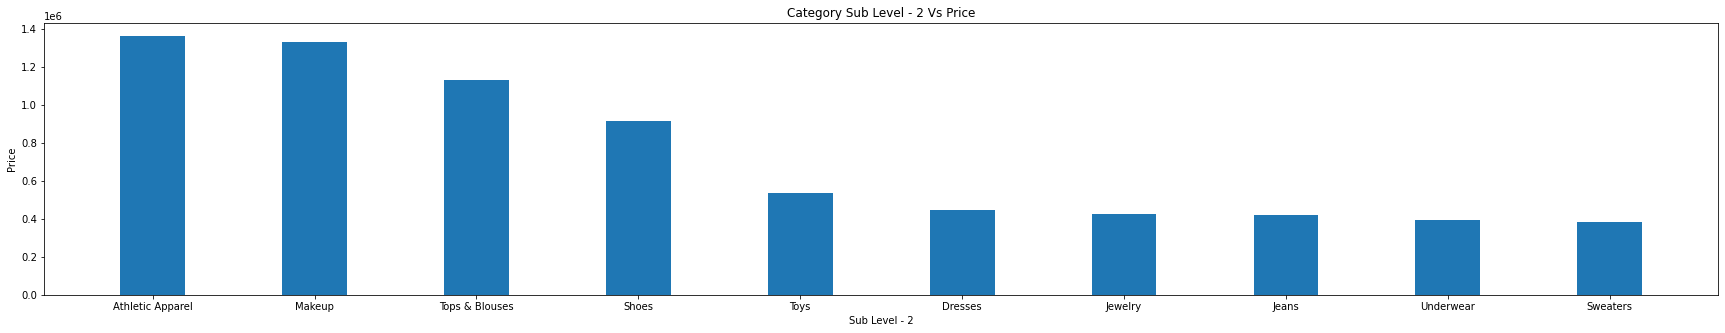

In [76]:
keys = cate_data.groupby(['sub_l2'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_l2']
values = cate_data.groupby(['sub_l2'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:10]), list(values[:10]), width = 0.4)
plt.title('Category Sub Level - 2 Vs Price')
plt.ylabel('Price')
plt.xlabel('Sub Level - 2')
plt.show()

In [77]:
sub_2_data = cate_data.groupby(['sub_l2'], dropna=True, as_index=False).mean().sort_values('price', ascending=False)[:10]
sub_2_data

sub_l2      price
93                    Suits  21.107143
12    Blazers & Sport Coats  19.750000
86                  Serving  19.432555
21   Car Audio, Video & GPS  19.386555
11                  Bedding  19.236224
53          Home Appliances  19.184776
87                    Shoes  19.054785
28          Coats & Jackets  18.822455
40                 Footwear  18.724138
111        Women's Handbags  18.661705

Text(0.5, 0, 'Sub Level - 2')

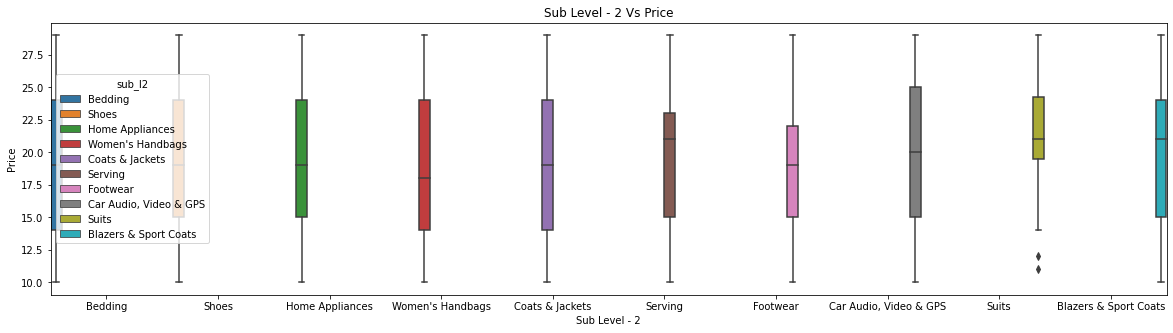

In [78]:
plt.figure(figsize=(20, 5))
plt.title('Sub Level - 2 Vs Price')
sns.boxplot(x = "sub_l2", y = "price", hue = "sub_l2", data=cate_data.loc[cate_data['sub_l2'].isin(list(sub_2_data['sub_l2']))], width=1)
plt.ylabel('Price')
plt.xlabel('Sub Level - 2')

Sub Level 2 also confirms that price of electronics products are higher than others. 

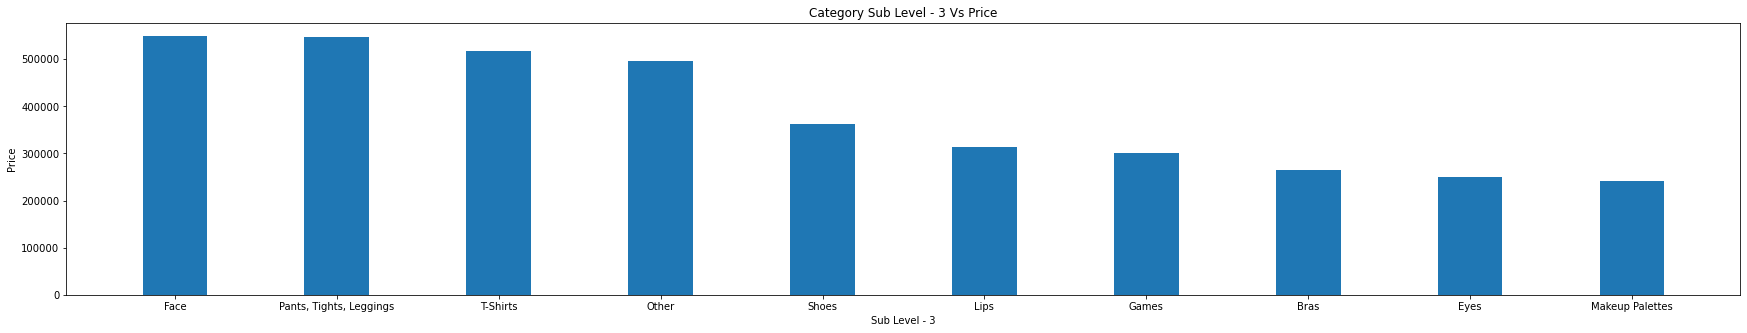

In [79]:
keys = cate_data.groupby(['sub_l3'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_l3']
values = cate_data.groupby(['sub_l3'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:10]), list(values[:10]), width = 0.4)
plt.title('Category Sub Level - 3 Vs Price')
plt.ylabel('Price')
plt.xlabel('Sub Level - 3')
plt.show()

In [80]:
sub_3_data = cate_data.groupby(['sub_l3'], dropna=True, as_index=False).mean().sort_values('price', ascending=False)[:10]
sub_3_data

sub_l3      price
217                        Cozy  29.000000
154  Car Security & Convenience  26.333333
583                    Planters  26.000000
483                         Map  26.000000
697                       Sport  25.000000
620      RV Parts & Accessories  25.000000
173                       Chair  25.000000
179              Child Friendly  25.000000
87                      Blanket  24.750000
394                      Horror  24.500000

Text(0.5, 0, 'Sub Level - 3')

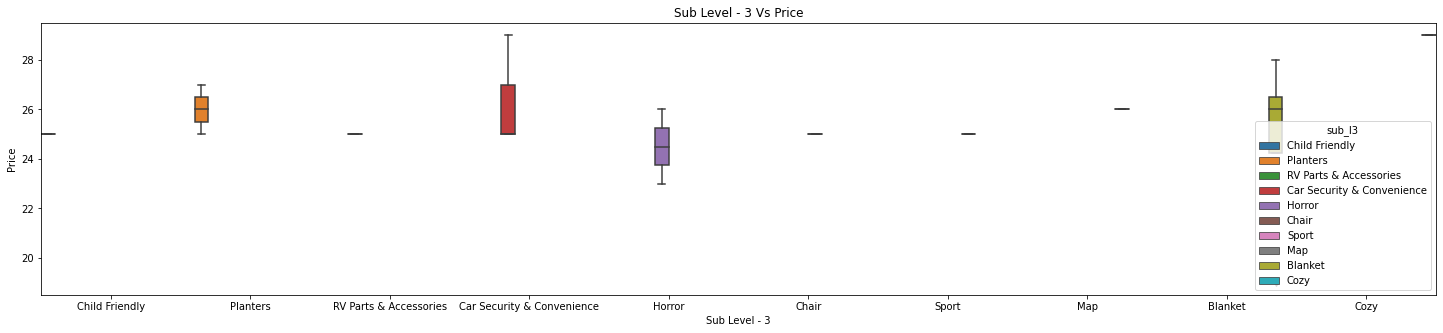

In [81]:
plt.figure(figsize=(25, 5))
plt.title('Sub Level - 3 Vs Price')
sns.boxplot(x = "sub_l3", y = "price", hue = "sub_l3", data=cate_data.loc[cate_data['sub_l3'].isin(list(sub_3_data['sub_l3']))], width=1)
plt.ylabel('Price')
plt.xlabel('Sub Level - 3')

Sub Level 3 also confirms that price of electronics products are higher than others.

### * Classifying Product as Cheap, Affordable and Expensive:

In [82]:
df['price'].describe()

count    1.481661e+06
mean     2.675329e+01
std      3.859198e+01
min      3.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

#### * Classification:
        
        * Cheap      : First 25% of price (i.e) price <= 10
        * Affordable : 50%-75% of price (i.e) price > 10 and <= 29
        * Expensive  : Greater than 75% of price (i.e) price > 29

In [83]:
cheap_df = df.loc[df['price'] <= 10].copy()
cheap_df.head(2)

name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
2                              AVA-VIV Blouse                  1   

                        category_name brand_name  price  shipping  \
train_id                                                            
0                   Men/Tops/T-shirts        NaN   10.0         1   
2         Women/Tops & Blouses/Blouse     Target   10.0         1   

                                           item_description  log_price  
train_id                                                                
0                                        No description yet   2.302585  
2         Adorable top with a hint of lace and a key hol...   2.302585

In [84]:
affordable_df = df.loc[(df['price'] > 10) & (df['price'] <= 29)].copy()
affordable_df.head(2)

name  item_condition_id  \
train_id                                             
8         Girls Nike Pro shorts                  3   
12           Black Skater dress                  2   

                            category_name brand_name  price  shipping  \
train_id                                                                
8         Sports & Outdoors/Apparel/Girls       Nike   19.0         0   
12         Women/Dresses/Above Knee, Mini        rue   16.0         0   

                                          item_description  log_price  
train_id                                                               
8         Girls Size small Plus green. Three shorts total.   2.944439  
12                                     Xl, great condition   2.772589

In [85]:
expensive_df = df.loc[df['price'] > 29].copy()
expensive_df.head(2)

name  item_condition_id  \
train_id                                                        
1         Razer BlackWidow Chroma Keyboard                  3   
3                    Leather Horse Statues                  1   

                                              category_name brand_name  price  \
train_id                                                                        
1         Electronics/Computers & Tablets/Components & P...      Razer   52.0   
3                        Home/Home Décor/Home Décor Accents        NaN   35.0   

          shipping                                   item_description  \
train_id                                                                
1                0  This keyboard is in great condition and works ...   
3                1  New with tags. Leather horses. Retail for [rm]...   

          log_price  
train_id             
1          3.951244  
3          3.555348

#### * Cheap Product Analysis:

In [86]:
print('Count of items does not have Brand name:', len(cheap_df.loc[cheap_df['brand_name'].isna(), 'brand_name']))
print('Count of items have Brand name:', len(cheap_df.loc[cheap_df['brand_name'].notna(), 'brand_name']))

Count of items does not have Brand name: 215456
Count of items have Brand name: 160159


In [87]:
(215456 / (215456 + 160159)) * 100

57.36086152043981

* As we can see here, 57% of Cheap products does not have Brand name.
* Logically, price branded products have much higher than non branded product.
* Cheap products, mostly doest not belong to brand. 

In [88]:
cheap_df.dropna(inplace=True)
cheap_df.head(2)

name  item_condition_id  \
train_id                                                            
2                               AVA-VIV Blouse                  1   
7         Girls cheer and tumbling bundle of 7                  3   

                            category_name brand_name  price  shipping  \
train_id                                                                
2             Women/Tops & Blouses/Blouse     Target   10.0         1   
7         Sports & Outdoors/Apparel/Girls      Soffe    6.0         1   

                                           item_description  log_price  
train_id                                                                
2         Adorable top with a hint of lace and a key hol...   2.302585  
7         You get three pairs of Sophie cheer shorts siz...   1.791759

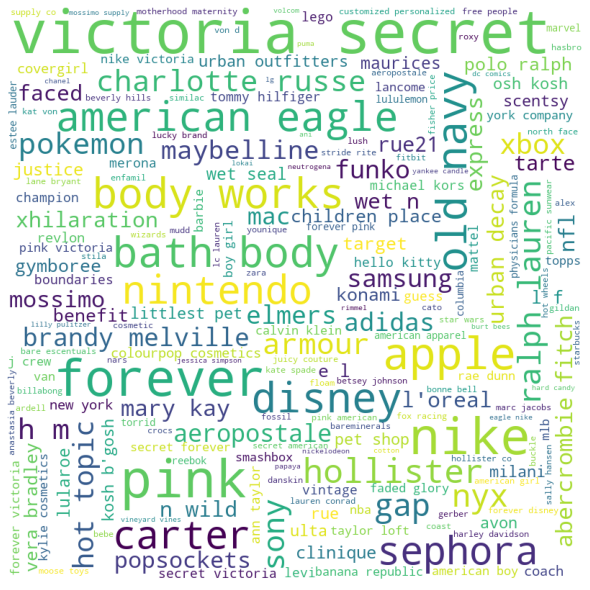

In [89]:
cheap_data = cheap_df.loc[:, 'brand_name'].str.lower()

cheap_data = ' '.join(cheap_data)
wordcloud_cheap_data = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cheap_data)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* We can see from above word cloud, some branded items also present.

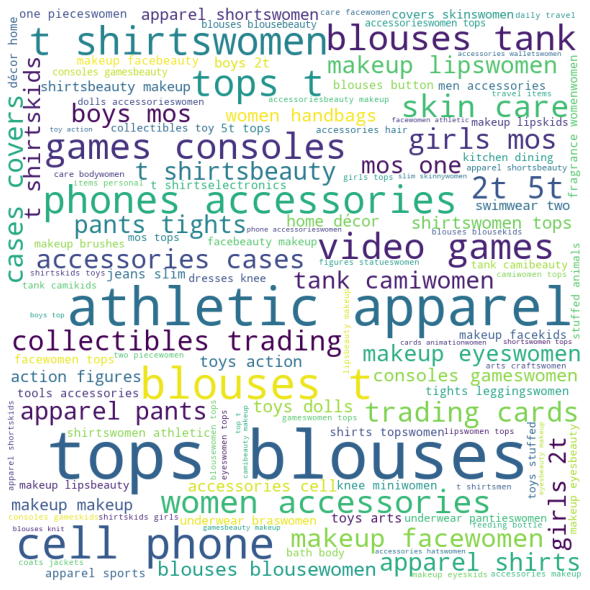

In [90]:
cheap_data = cheap_df.loc[:, 'category_name'].str.lower()

cheap_data = ''.join(cheap_data)
wordcloud_cheap_data = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cheap_data)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* As we can see from above word cloud, mostly branded cheap products contains
    * Cloting items.
    * Phone accessories.
    * Beauty product.
    * Toys.
    * Games.

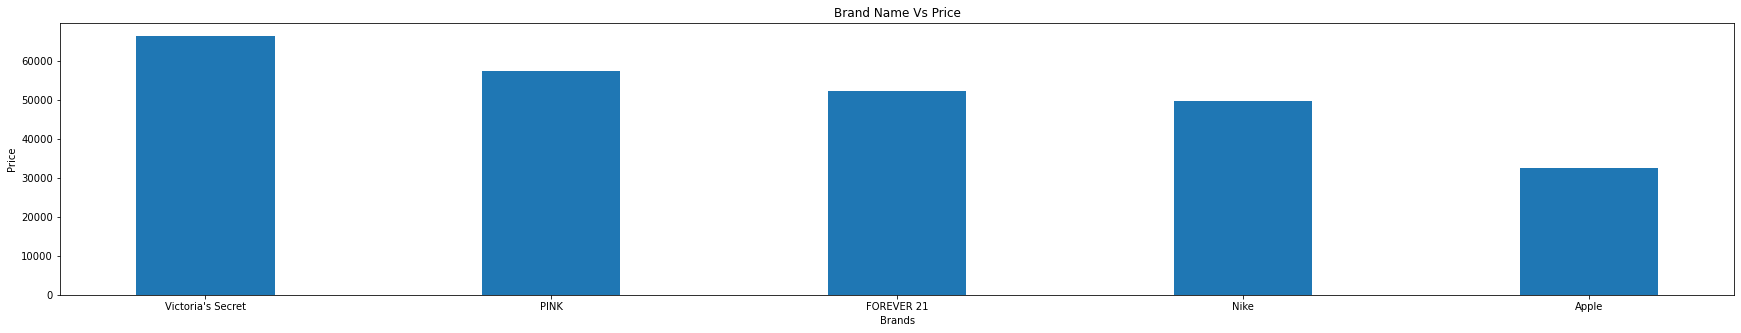

In [91]:
keys = cheap_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']
values = cheap_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:5]), list(values[:5]), width = 0.4)
plt.title('Brand Name Vs Price')
plt.ylabel('Price')
plt.xlabel('Brands')
plt.show()

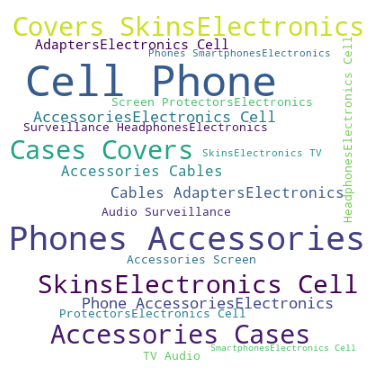

In [92]:
# Apple product under Cheap Category

cheap_data = cheap_df.loc[cheap_df['brand_name'] == 'Apple']['category_name']

cheap_data = ''.join(cheap_data)
wordcloud_cheap_data = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(cheap_data)

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

#### * Affordable Product Analysis:

In [93]:
print('Count of items does not have Brand name:', len(affordable_df.loc[affordable_df['brand_name'].isna(), 'brand_name']))
print('Count of items have Brand name:', len(affordable_df.loc[affordable_df['brand_name'].notna(), 'brand_name']))

Count of items does not have Brand name: 304134
Count of items have Brand name: 433786


In [94]:
(304134 / (304134 + 433786)) * 100

41.215036860364265

* As we can see here, 41% of Affordable products does not have Brand name.
* Most of the branded product also have some of its items in affordable range.

In [95]:
affordable_df.dropna(inplace=True)
affordable_df.head(2)

name  item_condition_id  \
train_id                                             
8         Girls Nike Pro shorts                  3   
12           Black Skater dress                  2   

                            category_name brand_name  price  shipping  \
train_id                                                                
8         Sports & Outdoors/Apparel/Girls       Nike   19.0         0   
12         Women/Dresses/Above Knee, Mini        rue   16.0         0   

                                          item_description  log_price  
train_id                                                               
8         Girls Size small Plus green. Three shorts total.   2.944439  
12                                     Xl, great condition   2.772589

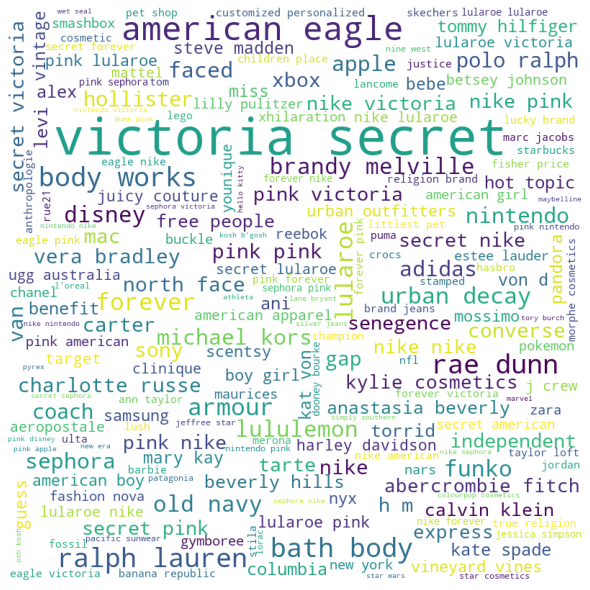

In [96]:
aff_data = affordable_df.loc[:, 'brand_name'].str.lower()

aff_data = ' '.join(aff_data)
wordcloud_cheap_data = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(aff_data)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* We can see from above word cloud, some mid leve branded items as well as top level branded items are present.

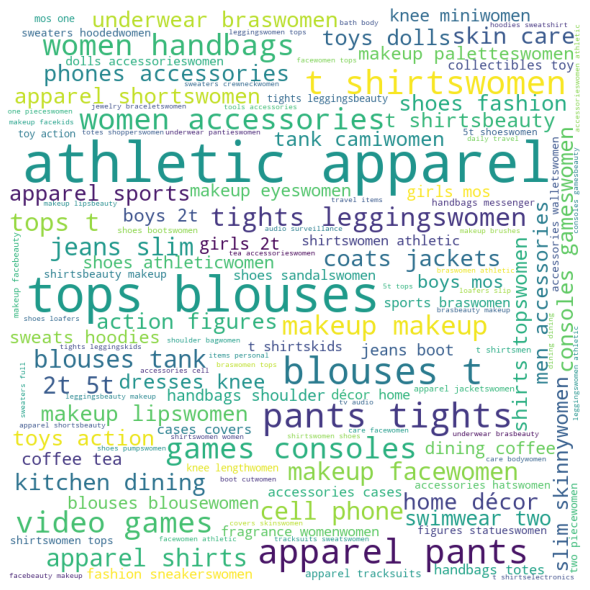

In [97]:
aff_data = affordable_df.loc[:, 'category_name'].str.lower()

aff_data = ''.join(aff_data)
wordcloud_cheap_data = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(aff_data)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* As we can see from above word cloud, mostly affordable products contains same as cheap produts,
    * Clothing items. Here Clothing have athletic items also, usually athletic items are more costlier than normal cloths. 
    * Phone accessories.
    * Beauty product.
    * Toys.
    * Games.

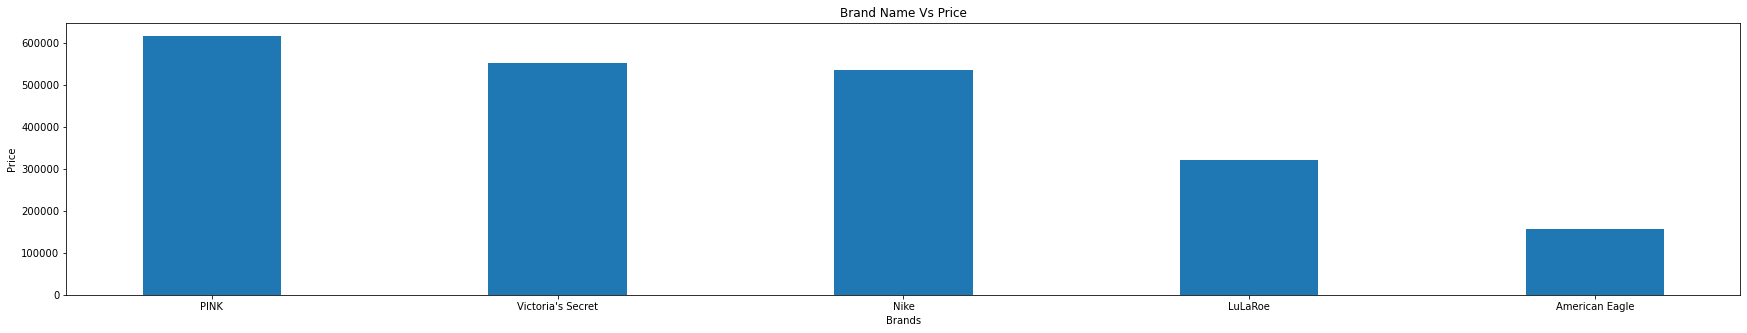

In [98]:
keys = affordable_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']
values = affordable_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:5]), list(values[:5]), width = 0.4)
plt.title('Brand Name Vs Price')
plt.ylabel('Price')
plt.xlabel('Brands')
plt.show()

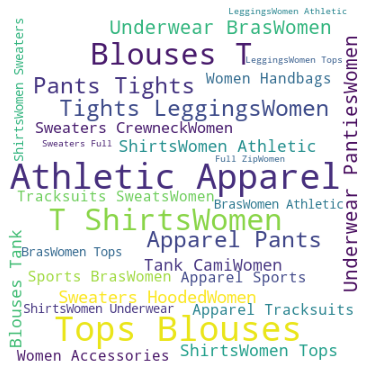

In [99]:
# PINK product under Affordable Category

aff_data = affordable_df.loc[affordable_df['brand_name'] == 'PINK']['category_name']

aff_data = ''.join(aff_data)
wordcloud_cheap_data = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(aff_data)

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

#### * Expensive Product Analysis:

In [100]:
print('Count of items does not have Brand name:', len(expensive_df.loc[expensive_df['brand_name'].isna(), 'brand_name']))
print('Count of items have Brand name:', len(expensive_df.loc[expensive_df['brand_name'].notna(), 'brand_name']))

Count of items does not have Brand name: 112746
Count of items have Brand name: 255380


In [101]:
(112746 / (112746 + 255380)) * 100

30.627013576873136

* As we can see here, only 30% of products does not have Brand name.
* Costiler items usually are branded product.

In [102]:
expensive_df.dropna(inplace=True)
expensive_df.head(2)

name  item_condition_id  \
train_id                                                          
1           Razer BlackWidow Chroma Keyboard                  3   
6         Acacia pacific tides santorini top                  3   

                                              category_name       brand_name  \
train_id                                                                       
1         Electronics/Computers & Tablets/Components & P...            Razer   
6                                  Women/Swimwear/Two-Piece  Acacia Swimwear   

          price  shipping                                   item_description  \
train_id                                                                       
1          52.0         0  This keyboard is in great condition and works ...   
6          64.0         0  Size small but straps slightly shortened to fi...   

          log_price  
train_id             
1          3.951244  
6          4.158883

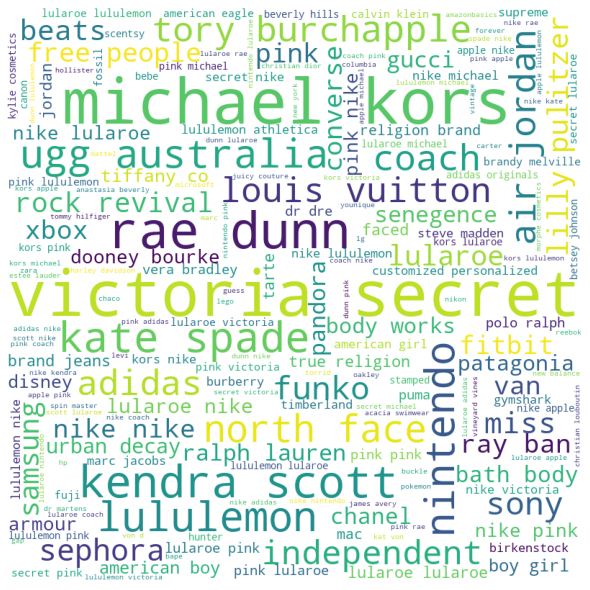

In [103]:
exp_data = expensive_df.loc[:, 'brand_name'].str.lower()

exp_data = ' '.join(exp_data)
wordcloud_cheap_data = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(exp_data)

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

* We can see from above word cloud, top branded items are present in expensive category.

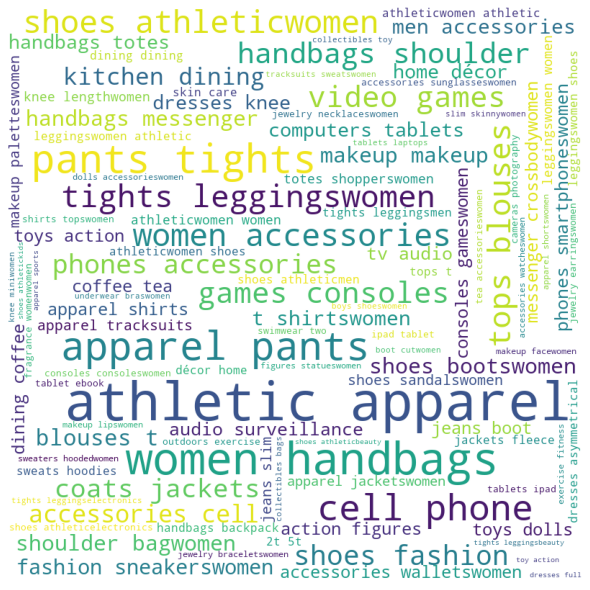

In [104]:
exp_data = expensive_df.loc[:, 'category_name'].str.lower()

exp_data = ''.join(exp_data)
wordcloud_cheap_data = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(exp_data)

plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

* As we can see from above word cloud, mostly branded cheap products contains
    * Cloting items (includes Althelic wear).
    * Phone, Ipad and its accessories.
    * Wooden meterials.
    * Women handbags.
    * Games Consoles.

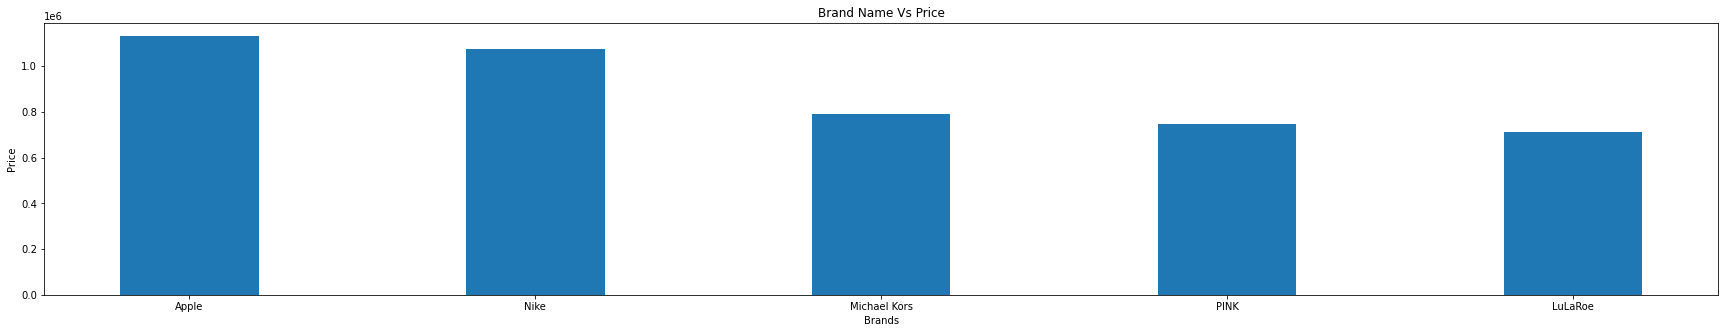

In [105]:
keys = expensive_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']
values = expensive_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['price']

fig = plt.figure(figsize = (30, 5))
plt.bar(list(keys[:5]), list(values[:5]), width = 0.4)
plt.title('Brand Name Vs Price')
plt.ylabel('Price')
plt.xlabel('Brands')
plt.show()

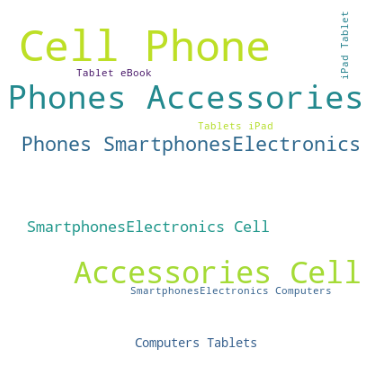

In [106]:
# Apple product under Expensive Category

exp_data = expensive_df.loc[expensive_df['brand_name'] == 'Apple']['category_name']

exp_data = ''.join(exp_data)
wordcloud_cheap_data = WordCloud(width = 400, height = 400, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(exp_data)

plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud_cheap_data)
plt.axis("off") 
plt.tight_layout(pad = 0)
plt.show()

* Almost all item types like cloths, etc,. are present in all the three categories (Cheap, Affordable and Expensive).
* In both Cheap and Affordable categories clothes are predominantly present.
* But in expensive category electronic items are present predominantly present. 

#### * Comparing Cheap and Affordable Items:

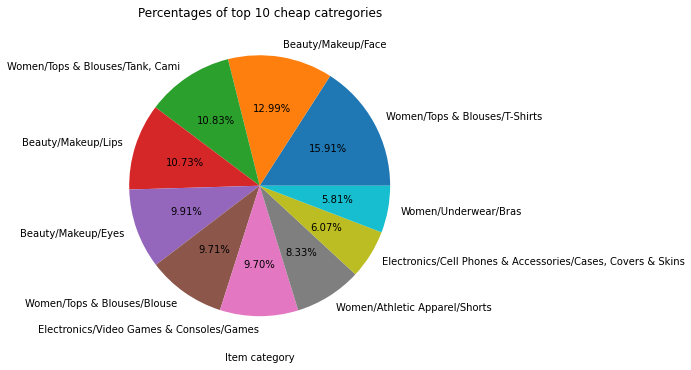

In [107]:
cheap_df['category_name'].value_counts()[:10].plot.pie(autopct="%.2f%%", figsize=(11, 6))
plt.title('Percentages of top 10 cheap catregories')
plt.ylabel('')
plt.xlabel('Item category')
plt.show()

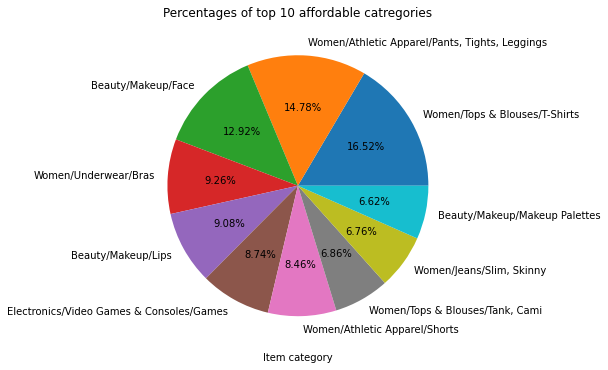

In [108]:
affordable_df['category_name'].value_counts()[:10].plot.pie(autopct="%.2f%%", figsize=(11, 6))
plt.title('Percentages of top 10 affordable catregories')
plt.ylabel('')
plt.xlabel('Item category')
plt.show()

Both cheap and affordable categories similar type items are present.

#### * Finding reason, why similar items have falls under different price ranges ?

In [109]:
# Taking top 5 brands in both categoties and collecting brands which are present in those top 5.

ch_keys = cheap_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']
af_keys = affordable_df.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']
top_five = list(set(ch_keys[:5]).intersection(af_keys[:5]))
print(top_five)

["Victoria's Secret", 'Nike', 'PINK']


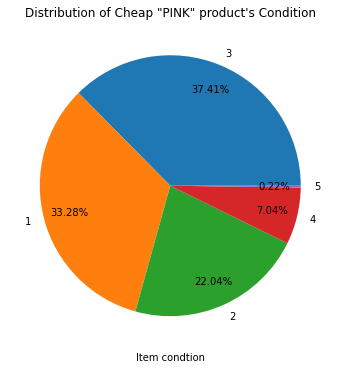

In [110]:
cheap_df.loc[cheap_df['brand_name'] == 'PINK']['item_condition_id'].value_counts().plot.pie(
    autopct="%.2f%%", pctdistance=0.8, figsize=(11, 6))
plt.title('Distribution of Cheap "PINK" product\'s Condition')
plt.ylabel('')
plt.xlabel('Item condtion')
plt.show()

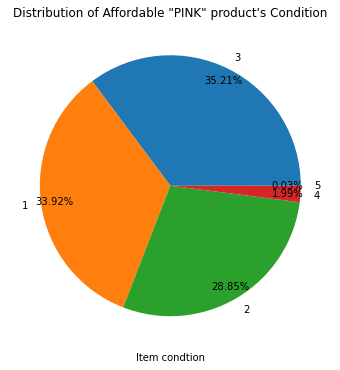

In [111]:
affordable_df.loc[affordable_df['brand_name'] == 'PINK']['item_condition_id'].value_counts().plot.pie(
    autopct="%.2f%%", pctdistance=0.9, figsize=(11, 6))
plt.title('Distribution of Affordable "PINK" product\'s Condition')
plt.ylabel('')
plt.xlabel('Item condtion')
plt.show()

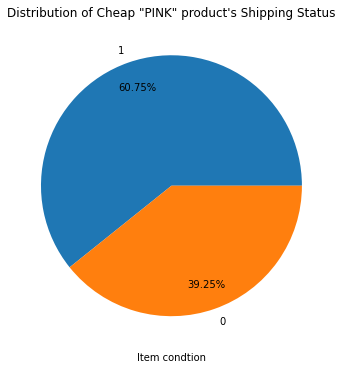

In [112]:
cheap_df.loc[cheap_df['brand_name'] == 'PINK']['shipping'].value_counts().plot.pie(
    autopct="%.2f%%", pctdistance=0.8, figsize=(11, 6))
plt.title('Distribution of Cheap "PINK" product\'s Shipping Status')
plt.ylabel('')
plt.xlabel('Item condtion')
plt.show()

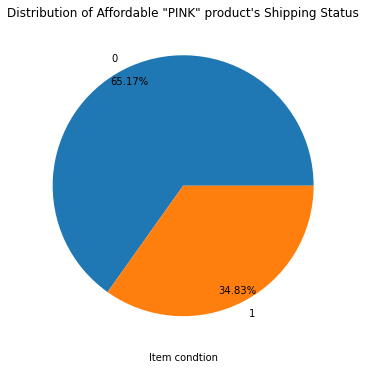

In [113]:
affordable_df.loc[affordable_df['brand_name'] == 'PINK']['shipping'].value_counts().plot.pie(
    autopct="%.2f%%", pctdistance=0.9, figsize=(11, 6))
plt.title('Distribution of Affordable "PINK" product\'s Shipping Status')
plt.ylabel('')
plt.xlabel('Item condtion')
plt.show()

* Above pie charts, shows the item condition of "PINK" branded items under both cheap and affordable categories.
* Item condition of "PINK" branded items under both categories does not differ much.
* Shipping status is also differ much.

In [114]:
sizes = ['small', 'medium', 'large', 'extra large', '3xs', 'xxs','xs', 's', 'm', 'l', 'xl', 'xxl', '3xl', '4xl']

In [115]:
cheap_data = ''.join(list(cheap_df.loc[cheap_df['brand_name'] == 'PINK']['item_description'].str.lower())).split()

cheap_map = {}

for i in sizes:
    cnt = cheap_data.count(i)
    if cnt > 0:
        cheap_map[i] = cnt
    
print(cheap_map)

{'small': 781, 'medium': 451, 'large': 316, 'xs': 270, 's': 64, 'm': 134, 'l': 61, 'xl': 8}


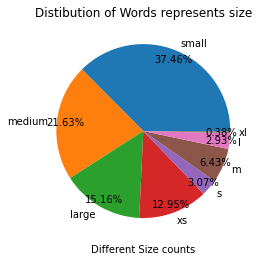

In [116]:
plt.pie([v for v in cheap_map.values()], labels=[k for k in cheap_map.keys()], 
        autopct="%.2f%%", pctdistance=0.9)
plt.title('Distibution of Words represents size')
plt.xlabel('Different Size counts')
plt.show()

In [117]:
aff_data = ''.join(list(affordable_df.loc[affordable_df['brand_name'] == 'PINK']['item_description'].str.lower())).split()

aff_map = {}

for i in sizes:
    cnt = aff_data.count(i)
    if cnt > 1:
        aff_map[i] = cnt
    
print(aff_map)

{'small': 3692, 'medium': 2472, 'large': 2066, 'xs': 1543, 's': 348, 'm': 478, 'l': 375, 'xl': 54}


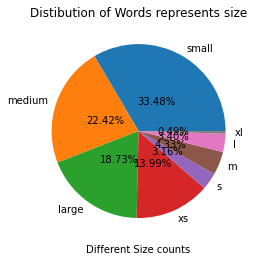

In [118]:
plt.pie([v for v in aff_map.values()], labels=[k for k in aff_map.keys()], 
        autopct="%.2f%%", pctdistance=0.4)
plt.title('Distibution of Words represents size')
plt.xlabel('Different Size counts')
plt.show()

Things like

    * Small impact of Shipping status, 
    * Products which have extra feature, 
    * Size of product, 
altogether classifies the same branded and type into cheap and affordable groups. 

### * Item Condition + Shipping Status Vs Price:

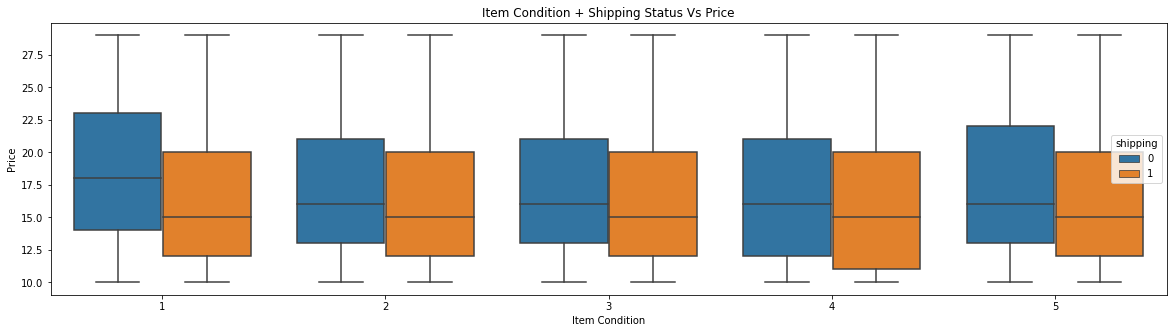

In [119]:
plt.figure(figsize=(20,5))
sns.boxplot(y='price', x='item_condition_id', data=df.loc[((df['price']>=10) & (df['price']<=29))], hue="shipping")
plt.title('Item Condition + Shipping Status Vs Price')
plt.xlabel('Item Condition')
plt.ylabel('Price')
plt.show()

* Price of products which have shipping status '0' (i.e) needs to pay shipping charge by user is higher that shipping status '1' (i.e) paid by seller.
* Usually Price shipping status '0' should be lesser than shipping status '1', since shipping status '1' because it inclueds the shipping charge as well.

#### * Brand name + Shipping Status Vs Brands:

In [120]:
data = df.loc[((df['price']>=10) & (df['price']<=29))].copy()
data.head()

name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
2                              AVA-VIV Blouse                  1   
8                       Girls Nike Pro shorts                  3   
12                         Black Skater dress                  2   
15                Sephora tarte birthday gift                  1   

                            category_name brand_name  price  shipping  \
train_id                                                                
0                       Men/Tops/T-shirts        NaN   10.0         1   
2             Women/Tops & Blouses/Blouse     Target   10.0         1   
8         Sports & Outdoors/Apparel/Girls       Nike   19.0         0   
12         Women/Dresses/Above Knee, Mini        rue   16.0         0   
15              Beauty/Makeup/Makeup Sets      Tarte   11.0         1   

                                           item_description  log_price  
train_id                                                                
0                                        No description yet   2.302585  
2         Adorable top with a hint of lace and a key hol...   2.302585  
8          Girls Size small Plus green. Three shorts total.   2.944439  
12                                      Xl, great condition   2.772589  
15        Brand new. Deluxe travel size products. Contai...   2.397895

In [121]:
print(len(data))

837336


In [122]:
brands = data.groupby(['brand_name'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['brand_name']

brands = list(brands[:10])
print('Top 10 Brands', brands)

top_brands = data.loc[data['brand_name'].isin(brands)]
top_brands.head(2)

Top 10 Brands ['PINK', "Victoria's Secret", 'Nike', 'LuLaRoe', 'American Eagle', 'FOREVER 21', 'Nintendo', 'Sephora', 'Rae Dunn', 'Apple']


name  item_condition_id  \
train_id                                                        
8                    Girls Nike Pro shorts                  3   
21        NWT VS ULTIMATE SPORTS BRA 34ddd                  1   

                               category_name         brand_name  price  \
train_id                                                                 
8            Sports & Outdoors/Apparel/Girls               Nike   19.0   
21        Women/Athletic Apparel/Sports Bras  Victoria's Secret   20.0   

          shipping                                   item_description  \
train_id                                                                
8                0   Girls Size small Plus green. Three shorts total.   
21               0  NWT Victoria's Secret ULTIMATE SPORT BRA -MAXI...   

          log_price  
train_id             
8          2.944439  
21         2.995732

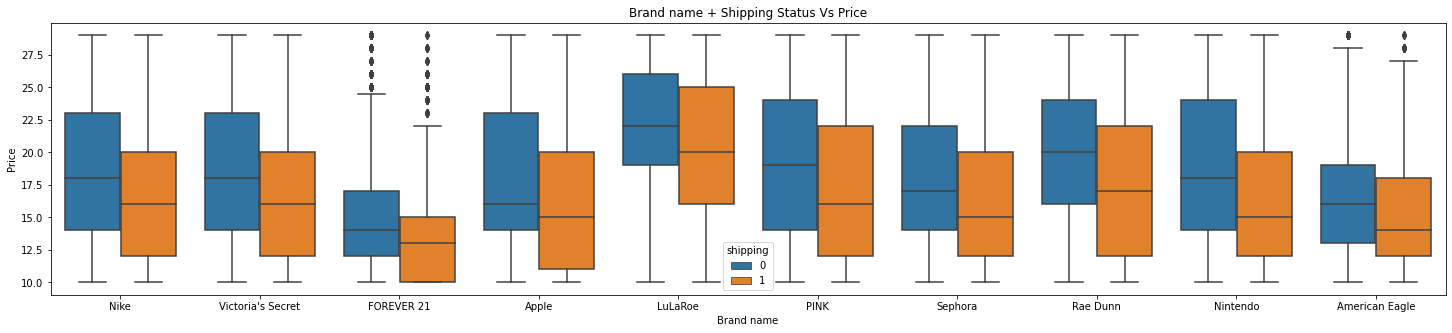

In [123]:
plt.figure(figsize=(25,5))
sns.boxplot(y='price', x='brand_name', data=top_brands, hue='shipping')
plt.title('Brand name + Shipping Status Vs Price')
plt.xlabel('Brand name')
plt.ylabel('Price')
plt.show()

* "Brand name + Shipping Status Vs Price" is also refelects same as "Item Condition + Shipping Status Vs Price".

#### * Categories + Shipping Status Vs Brands:

In [124]:
cat_data = data['category_name'].str.split('/')

sub_level_1 = []
sub_level_2 = []
sub_level_3 = []

for i in cat_data:
    if i != i:
        sub_level_1.append('')
        sub_level_2.append('')
        sub_level_3.append('')
    else:
        sub_level_1.append(i[0])
        sub_level_2.append(i[1])
        sub_level_3.append(i[2])

In [125]:
data['sub_level_1'] = sub_level_1
data['sub_level_2'] = sub_level_2
data['sub_level_3'] = sub_level_3
data.head(2)

name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
2                              AVA-VIV Blouse                  1   

                        category_name brand_name  price  shipping  \
train_id                                                            
0                   Men/Tops/T-shirts        NaN   10.0         1   
2         Women/Tops & Blouses/Blouse     Target   10.0         1   

                                           item_description  log_price  \
train_id                                                                 
0                                        No description yet   2.302585   
2         Adorable top with a hint of lace and a key hol...   2.302585   

         sub_level_1     sub_level_2 sub_level_3  
train_id                                          
0                Men            Tops    T-shirts  
2              Women  Tops & Blouses      Blouse

Top 10 sub_level_1 Categories
 ['Women', 'Beauty', 'Kids', 'Electronics', 'Men']


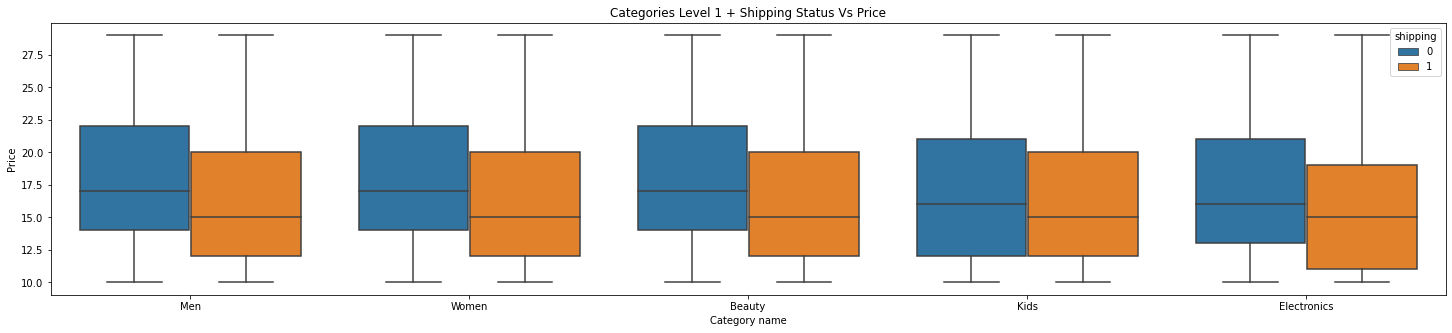

In [126]:
categ = data.groupby(['sub_level_1'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_level_1']

print('Top 10 sub_level_1 Categories\n', list(categ[:5]))

top_categ = data.loc[data['sub_level_1'].isin(list(categ[:5]))]
top_categ.head(2)

plt.figure(figsize=(25,5))
sns.boxplot(y='price', x='sub_level_1', data=top_categ, hue='shipping')
plt.title('Categories Level 1 + Shipping Status Vs Price')
plt.xlabel('Category name')
plt.ylabel('Price')
plt.show()

Top 10 sub_level_2 Categories
 ['Athletic Apparel', 'Makeup', 'Tops & Blouses', 'Shoes', 'Toys']


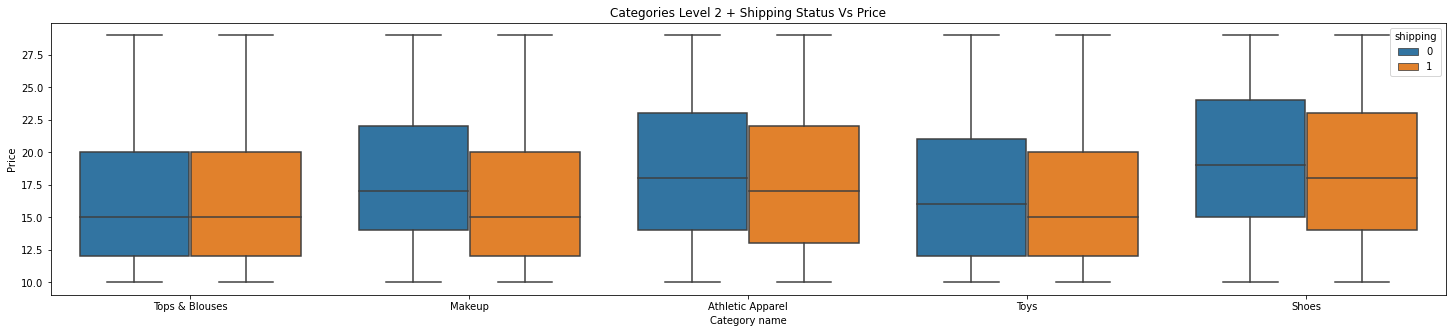

In [127]:
categ = data.groupby(['sub_level_2'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_level_2']

print('Top 10 sub_level_2 Categories\n', list(categ[:5]))

top_categ = data.loc[data['sub_level_2'].isin(list(categ[:5]))]
top_categ.head(2)

plt.figure(figsize=(25,5))
sns.boxplot(y='price', x='sub_level_2', data=top_categ, hue='shipping')
plt.title('Categories Level 2 + Shipping Status Vs Price')
plt.xlabel('Category name')
plt.ylabel('Price')
plt.show()

Top 10 sub_level_3 Categories
 ['Face', 'Pants, Tights, Leggings', 'T-Shirts', 'Other', 'Shoes']


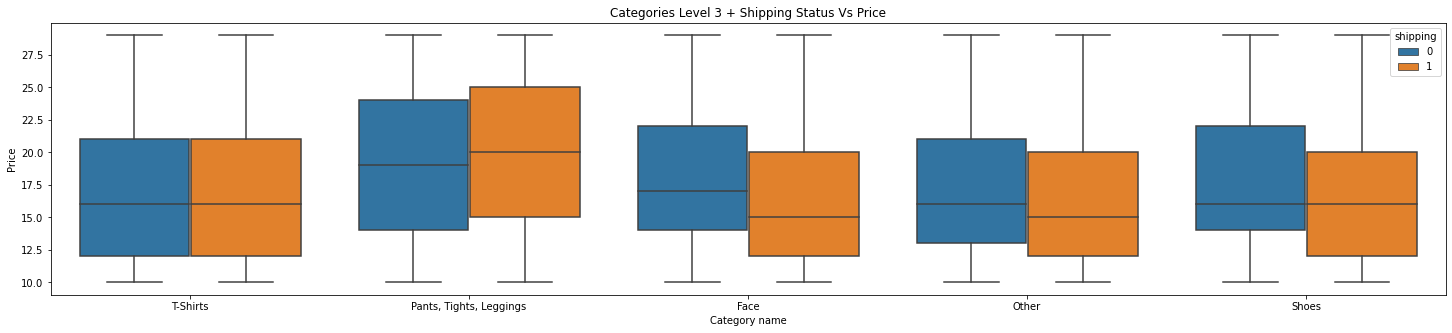

In [128]:
categ = data.groupby(['sub_level_3'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_level_3']

print('Top 10 sub_level_3 Categories\n', list(categ[:5]))

top_categ = data.loc[data['sub_level_3'].isin(list(categ[:5]))]
top_categ.head(2)

plt.figure(figsize=(25,5))
sns.boxplot(y='price', x='sub_level_3', data=top_categ, hue='shipping')
plt.title('Categories Level 3 + Shipping Status Vs Price')
plt.xlabel('Category name')
plt.ylabel('Price')
plt.show()

In [129]:
categ = data.groupby(['sub_level_1'], dropna=True, as_index=False).sum().sort_values('price', ascending=False)['sub_level_1']

print('Top 10 sub_level_1 Categories\n', list(categ[:5]))

top_categ = data.loc[data['sub_level_1'].isin(list(categ[:5]))]
top_categ.head(2)

Top 10 sub_level_1 Categories
 ['Women', 'Beauty', 'Kids', 'Electronics', 'Men']


name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
2                              AVA-VIV Blouse                  1   

                        category_name brand_name  price  shipping  \
train_id                                                            
0                   Men/Tops/T-shirts        NaN   10.0         1   
2         Women/Tops & Blouses/Blouse     Target   10.0         1   

                                           item_description  log_price  \
train_id                                                                 
0                                        No description yet   2.302585   
2         Adorable top with a hint of lace and a key hol...   2.302585   

         sub_level_1     sub_level_2 sub_level_3  
train_id                                          
0                Men            Tops    T-shirts  
2              Women  Tops & Blouses      Blouse

In [130]:
top_categ = top_categ.groupby(['shipping', 'sub_level_1']).sum().reset_index()
top_categ_0 = top_categ.loc[top_categ['shipping']==0]
top_categ_1 = top_categ.loc[top_categ['shipping']==1]

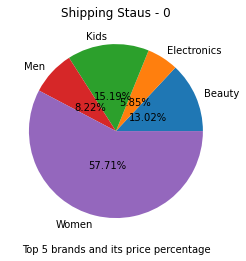

In [131]:
ship_cate = top_categ_0.groupby(['shipping', 'sub_level_1']).sum().reset_index()

ship_cate_map = {}

for index, row in ship_cate.iterrows():
    ship_cate_map[row['sub_level_1']] = row['price']
    
plt.pie([v for v in ship_cate_map.values()], labels=[k for k in ship_cate_map.keys()], 
        autopct="%.2f%%", pctdistance=0.4)
plt.title('Shipping Staus - 0')
plt.xlabel('Top 5 brands and its price percentage')
plt.show()

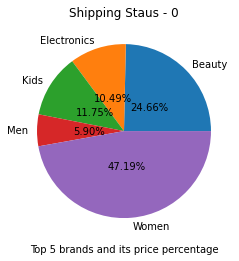

In [132]:
ship_cate = top_categ_1.groupby(['shipping', 'sub_level_1']).sum().reset_index()

ship_cate_map = {}

for index, row in ship_cate.iterrows():
    ship_cate_map[row['sub_level_1']] = row['price']
    
plt.pie([v for v in ship_cate_map.values()], labels=[k for k in ship_cate_map.keys()], 
        autopct="%.2f%%", pctdistance=0.4)
plt.title('Shipping Staus - 1')
plt.xlabel('Top 5 brands and its price percentage')
plt.show()

* Shipping Status 1 for Electronic items and Beauty Items are higher when compared to Shipping Status 0.
* Items for Men and women are higher in Shipping Status 0.
* Repetitive items have Shipping Status 0 (i.e) user needs to pay for shipping.

## * Data preprocessing and Feature Engineering:

In [82]:
df = pd.read_csv('Dataset/train.tsv', sep='\t', index_col='train_id')

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [83]:
df.head()

name  item_condition_id  \
train_id                                                           
0         MLB Cincinnati Reds T Shirt Size XL                  3   
1            Razer BlackWidow Chroma Keyboard                  3   
2                              AVA-VIV Blouse                  1   
3                       Leather Horse Statues                  1   
4                        24K GOLD plated rose                  1   

                                              category_name brand_name  price  \
train_id                                                                        
0                                         Men/Tops/T-shirts        NaN   10.0   
1         Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                               Women/Tops & Blouses/Blouse     Target   10.0   
3                        Home/Home Décor/Home Décor Accents        NaN   35.0   
4                                   Women/Jewelry/Necklaces        NaN   44.0   

          shipping                                   item_description  
train_id                                                               
0                1                                 No description yet  
1                0  This keyboard is in great condition and works ...  
2                1  Adorable top with a hint of lace and a key hol...  
3                1  New with tags. Leather horses. Retail for [rm]...  
4                0          Complete with certificate of authenticity

In [84]:
from nltk.corpus import stopwords

# Reference: NLP Assigments
def decontractions(phrase):
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase

def preprocess(text):
    text = text.lower()
    text = decontractions(text)
    text = re.sub('[^A-Za-z0-9 ]+', ' ', text)
    text = [t for t in text if t not in string.punctuation]
    return ''.join(text)

stop_words = set(stopwords.words("english"))

def removeStopWords(text):
    word_tokens = word_tokenize(text)  
    filtered_sentence = [w for w in word_tokens if not w in list(stop_words)] 
    filtered_sentence = ' '.join(filtered_sentence)
    return filtered_sentence

# def lemmatizer(text):
#     lem_text = [WordNetLemmatizer().lemmatize(i) for i in text.split(' ')]
#     return ''.join(lem_text)

sp = spacy.load('en_core_web_sm')

def lemmatizer(text):
    lem_text = sp(text)
    lem_text = [i.lemma_ for i in lem_text]
    return ' '.join(lem_text)

def remove_special_characters(text):
    pat = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    return re.sub(pat, '', text)

def num_to_word(text):
    digits = [int(s) for s in text.split() if s.isdigit()]
    digits_map = {str(i): num2words(i) for i in digits}
    for i in digits_map.keys():
        text = text.replace(i, digits_map[i])
    return text

def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

In [3]:
def remove_extra_whitespace_tabs(text):
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

In [13]:
a = '''We   can   use    Named   Entity   Recognizer   (NER)    to   ﬁlter   signiﬁcant   words   and   remove   
the   insigniﬁcant   words   and   repetitive   words   so   that   it   can   avoid   the   sparsity.   
'''
print(remove_extra_whitespace_tabs(a))

We can use Named Entity Recognizer (NER) to ﬁlter signiﬁcant words and remove the insigniﬁcant words and repetitive words so that it can avoid the sparsity.


In [85]:
df.loc[df['name'].isna(), 'name'] = 'missing'

In [86]:
df.loc[df['item_description'] == 'No description yet', ['item_description']] = 'missing'
df['item_description'].fillna('missing', inplace=True)
np.unique(df['item_description'].isna())

array([False])

In [87]:
df['name'] = df['name'].apply(preprocess)
df['name'] = df['name'].apply(lemmatizer)
df['name'] = df['name'].apply(remove_special_characters)
df['name'] = df['name'].apply(num_to_word)
df['name'] = df['name'].apply(remove_extra_whitespace_tabs)

In [88]:
df['item_description'] = df['item_description'].apply(preprocess)
df['item_description'] = df['item_description'].apply(removeStopWords)
df['item_description'] = df['item_description'].apply(lemmatizer)
df['item_description'] = df['item_description'].apply(remove_special_characters)
df['item_description'] = df['item_description'].apply(num_to_word)
df['item_description'] = df['item_description'].apply(remove_extra_whitespace_tabs)

In [89]:
df.head()

name  item_condition_id  \
train_id                                                           
0         mlb cincinnati reds t shirt size xl                  3   
1            razer blackwidow chroma keyboard                  3   
2                              ava viv blouse                  1   
3                        leather horse statue                  1   
4                         24k gold plate rise                  1   

                                              category_name brand_name  price  \
train_id                                                                        
0                                         Men/Tops/T-shirts        NaN   10.0   
1         Electronics/Computers & Tablets/Components & P...      Razer   52.0   
2                               Women/Tops & Blouses/Blouse     Target   10.0   
3                        Home/Home Décor/Home Décor Accents        NaN   35.0   
4                                   Women/Jewelry/Necklaces        NaN   44.0   

          shipping                                   item_description  
train_id                                                               
0                1                                               miss  
1                0  keyboard great condition work like come box po...  
2                1  adorable top hint lace key hole back pale pink...  
3                1  new tag leather horse retail rm stand foot hig...  
4                0                  complete certificate authenticity

In [90]:
level_1 = []
level_2 = []
level_3 = []

cate_list = df['category_name'].str.split('/')

for i in cate_list:
    if i != i:
        level_1.append('miss')
        level_2.append('miss')
        level_3.append('miss')
    else:
        level_1.append(i[0])
        level_2.append(i[1])
        level_3.append(i[2])
        
sub_l1 = pd.Series(level_1)
sub_l2 = pd.Series(level_2)
sub_l3 = pd.Series(level_3)

df.drop(columns=['category_name'], inplace=True)

In [91]:
df.head()

name  item_condition_id brand_name  \
train_id                                                                      
0         mlb cincinnati reds t shirt size xl                  3        NaN   
1            razer blackwidow chroma keyboard                  3      Razer   
2                              ava viv blouse                  1     Target   
3                        leather horse statue                  1        NaN   
4                         24k gold plate rise                  1        NaN   

          price  shipping                                   item_description  
train_id                                                                      
0          10.0         1                                               miss  
1          52.0         0  keyboard great condition work like come box po...  
2          10.0         1  adorable top hint lace key hole back pale pink...  
3          35.0         1  new tag leather horse retail rm stand foot hig...  
4          44.0         0                  complete certificate authenticity

In [92]:
df['sub_l1'] = sub_l1.str.lower()
df['sub_l2'] = sub_l2.str.lower()
df['sub_l3'] = sub_l3.str.lower()

In [93]:
df.head()

name  item_condition_id brand_name  \
train_id                                                                      
0         mlb cincinnati reds t shirt size xl                  3        NaN   
1            razer blackwidow chroma keyboard                  3      Razer   
2                              ava viv blouse                  1     Target   
3                        leather horse statue                  1        NaN   
4                         24k gold plate rise                  1        NaN   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

               sub_l1               sub_l2              sub_l3  
train_id                                                        
0                 men                 tops            t-shirts  
1         electronics  computers & tablets  components & parts  
2               women       tops & blouses              blouse  
3                home           home décor  home décor accents  
4               women              jewelry           necklaces

In [94]:
# df.to_csv('Dataset/train_preprocessed_1.tsv', sep="\t")

In [95]:
df = pd.read_csv('Dataset/train_preprocessed_1.tsv', sep='\t', index_col='train_id', na_values='')
df = df.fillna('')
df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


name  item_condition_id brand_name  \
train_id                                                                      
0         mlb cincinnati reds t shirt size xl                  3              
1            razer blackwidow chroma keyboard                  3      Razer   
2                              ava viv blouse                  1     Target   
3                        leather horse statue                  1              
4                         24k gold plate rise                  1              

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

               sub_l1               sub_l2              sub_l3  
train_id                                                        
0                 men                 tops            t-shirts  
1         electronics  computers & tablets  components & parts  
2               women       tops & blouses              blouse  
3                home           home décor  home décor accents  
4               women              jewelry           necklaces

#### * Filling Missing Values: Brand Name, Item Description:

In [96]:
known_brand_names = list(df.loc[df['brand_name'] != '', :].sort_values('brand_name')['brand_name'].str.lower())

In [97]:
brand, count = np.unique(known_brand_names, return_counts=True)
known_brand_names = {brand[i] : count[i] for i in range(len(brand))}

In [98]:
known_brand_names_up = []
for i, j in known_brand_names.items():
    if (j > 200):
        known_brand_names_up.append(i)

print(len(known_brand_names_up))
print(known_brand_names_up[:5])

377
['7 for all mankind®', 'abercrombie & fitch', 'acacia swimwear', 'aden & anais', 'adidas']


In [99]:
unknown_brand_names_df = df.copy().reset_index()
unknown_brand_names_df.head(2)

train_id                                 name  item_condition_id  \
0         0  mlb cincinnati reds t shirt size xl                  3   
1         1     razer blackwidow chroma keyboard                  3   

  brand_name  price  shipping  \
0              10.0         1   
1      Razer   52.0         0   

                                    item_description       sub_l1  \
0                                               miss          men   
1  keyboard great condition work like come box po...  electronics   

                sub_l2              sub_l3  
0                 tops            t-shirts  
1  computers & tablets  components & parts

In [100]:
unknown_brand_names_df = unknown_brand_names_df.loc[df['brand_name'] == '', ['train_id', 'name', 'item_description']]
merged_text = unknown_brand_names_df['name'] + ' ' + unknown_brand_names_df['item_description']
unknown_brand_names_df['merged_text'] = merged_text
unknown_brand_names_df.drop(columns=['name', 'item_description'], inplace=True)
unknown_brand_names_df.head(2)

train_id                                        merged_text
0         0           mlb cincinnati reds t shirt size xl miss
3         3  leather horse statue new tag leather horse ret...

In [101]:
train_id = list(unknown_brand_names_df['train_id'])
merged_text = list(unknown_brand_names_df['merged_text'])

unknown_brand_names_map = {train_id[i] : merged_text[i] for i in range(len(train_id))}

In [102]:
known_brand_names = []
for i in known_brand_names_up:
    if len(i) > 2:
        known_brand_names.append(i)

print(len(known_brand_names))

373


In [103]:
found_brands = {}
found_names = {}

for brand in tqdm(known_brand_names):
    for i, j in unknown_brand_names_map.items():
        if brand in j:
            found_brands[i] = brand

100%|████████████████████████████████████████████████████████████████████████████████| 373/373 [00:40<00:00,  9.17it/s]


In [104]:
for i, j in tqdm(found_brands.items()):
    df.loc[i, 'brand_name'] = j

100%|██████████████████████████████████████████████████████████████████████████| 282191/282191 [58:55<00:00, 79.82it/s]


In [105]:
df.head()

name  item_condition_id brand_name  \
train_id                                                                      
0         mlb cincinnati reds t shirt size xl                  3        mlb   
1            razer blackwidow chroma keyboard                  3      Razer   
2                              ava viv blouse                  1     Target   
3                        leather horse statue                  1              
4                         24k gold plate rise                  1              

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

               sub_l1               sub_l2              sub_l3  
train_id                                                        
0                 men                 tops            t-shirts  
1         electronics  computers & tablets  components & parts  
2               women       tops & blouses              blouse  
3                home           home décor  home décor accents  
4               women              jewelry           necklaces

In [106]:
df.loc[df['brand_name'] == '', 'brand_name'] = 'miss'

In [107]:
len(df.loc[df['brand_name'] == 'miss', 'brand_name'])

350491

In [108]:
(344735/(len(df) + 344735)) * 100

18.86612268575525

* From 42% we reduced missing values of "Brand Name" to 18%.
* Most of the missing values are filled with the help of known brand names.
* Initially, known brands which should listed more than 200 times are put in the list.
* Then Unknown brands 'name' and 'item description' are concated and put it in map as value, its index are put as key.
* With Looping, if known brand found in unknown brand map, we assing it as value and index as key in a new map.
* After doing the above steps, most of the missing values are filled, rest of the missing values are filled with keyword 'missing'.

In [109]:
df.loc[df['item_description'] == '', 'item_description'] = 'miss'

'Item Description' missing values are filled with keyword 'missing'.

In [110]:
print(len(df.loc[df['sub_l1'] == 'miss', 'price']))
print(len(df.loc[df['sub_l2'] == 'miss', 'price']))
print(len(df.loc[df['sub_l3'] == 'miss', 'price']))

6327
6327
6327


In [111]:
6327/(1476208+6327)*100

0.42676901388500105

In [112]:
print('Length of DF before dropping:', len(df))
df.drop(df[df['sub_l1'] == 'miss'].index, inplace = True)
print('Length of DF after dropping:', len(df))

Length of DF before dropping: 1482535
Length of DF after dropping: 1476208


In [113]:
print(len(df.loc[df['sub_l1'] == 'miss', 'price']))
print(len(df.loc[df['sub_l2'] == 'miss', 'price']))
print(len(df.loc[df['sub_l3'] == 'miss', 'price']))

0
0
0


Since, categories have just 4% percentage of missing values, it is dropped from the dataframe.

In [114]:
concate_bundle = list(df['name'] + ' ' + df['item_description'])

In [115]:
contains_bundle = []
a = 0
for i in concate_bundle:
    if (('bundles' in i) or ('bundle' in i)):
        contains_bundle.append(1)
    else:
        contains_bundle.append(0)

In [116]:
df['contains_bundle'] = contains_bundle

Since bundle of items increases the price, bundled feature might be helpful for the model.

In [117]:
# Reference: https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/ 
senti = SentimentIntensityAnalyzer() 
def get_sentiment_score(data):
    if data != 'miss':
        sentence_sentiment_score = senti.polarity_scores(data)
        compound = sentence_sentiment_score['compound']
        if compound >= 0.5:
            return 3 
        if compound >= (-0.5) and compound < 0.5:
            return 2
        if compound < (-0.5):
            return 1
    else: 
        return 0 

In [118]:
df['item_description_score'] = df['item_description'].apply(lambda x: get_sentiment_score(x))

Sentiment score is formed from item_description, since better the description of a product might result in better
selling.

In [119]:
df.head()

name  item_condition_id brand_name  \
train_id                                                                      
0         mlb cincinnati reds t shirt size xl                  3        mlb   
1            razer blackwidow chroma keyboard                  3      Razer   
2                              ava viv blouse                  1     Target   
3                        leather horse statue                  1       miss   
4                         24k gold plate rise                  1       miss   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

               sub_l1               sub_l2              sub_l3  \
train_id                                                         
0                 men                 tops            t-shirts   
1         electronics  computers & tablets  components & parts   
2               women       tops & blouses              blouse   
3                home           home décor  home décor accents   
4               women              jewelry           necklaces   

          contains_bundle  item_description_score  
train_id                                           
0                       0                       0  
1                       0                       3  
2                       0                       3  
3                       0                       3  
4                       0                       2

In [5]:
# df.to_csv('Dataset/train_preprocessed_2.tsv', sep="\t")

In [6]:
df = pd.read_csv('Dataset/train_preprocessed_2.tsv', sep='\t', index_col='train_id', na_values='')
df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


name  item_condition_id brand_name  \
train_id                                                                      
0         mlb cincinnati reds t shirt size xl                  3        mlb   
1            razer blackwidow chroma keyboard                  3      Razer   
2                              ava viv blouse                  1     Target   
3                        leather horse statue                  1       miss   
4                         24k gold plate rise                  1       miss   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

               sub_l1               sub_l2              sub_l3  \
train_id                                                         
0                 men                 tops            t-shirts   
1         electronics  computers & tablets  components & parts   
2               women       tops & blouses              blouse   
3                home           home décor  home décor accents   
4               women              jewelry           necklaces   

          contains_bundle  item_description_score  
train_id                                           
0                       0                       0  
1                       0                       3  
2                       0                       3  
3                       0                       3  
4                       0                       2

### * Feature Encoding:

#### * Item Description: Ordinal Encoding

In [122]:
exist_item_order = {5:'poor', 4:'fair', 3:'good', 2:'almost_new', 1:'new'}
new_item_order = {'poor':1, 'fair':2, 'good':3, 'almost_new':4, 'new':5}

In [123]:
np.unique(df['item_condition_id'], return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([638324, 373302, 430404,  31805,   2373], dtype=int64))

In [124]:
df['item_condition_id'].replace(1, exist_item_order[1], inplace=True)
df['item_condition_id'].replace(2, exist_item_order[2], inplace=True)
df['item_condition_id'].replace(3, exist_item_order[3], inplace=True)
df['item_condition_id'].replace(4, exist_item_order[4], inplace=True)
df['item_condition_id'].replace(5, exist_item_order[5], inplace=True)

In [125]:
np.unique(df['item_condition_id'], return_counts=True)

(array(['almost_new', 'fair', 'good', 'new', 'poor'], dtype=object),
 array([373302,  31805, 430404, 638324,   2373], dtype=int64))

In [126]:
df['item_condition_id'].replace(exist_item_order[1], new_item_order[exist_item_order[1]], inplace=True)
df['item_condition_id'].replace(exist_item_order[2], new_item_order[exist_item_order[2]], inplace=True)
df['item_condition_id'].replace(exist_item_order[3], new_item_order[exist_item_order[3]], inplace=True)
df['item_condition_id'].replace(exist_item_order[4], new_item_order[exist_item_order[4]], inplace=True)
df['item_condition_id'].replace(exist_item_order[5], new_item_order[exist_item_order[5]], inplace=True)

In [127]:
np.unique(df['item_condition_id'], return_counts=True)

(array([1, 2, 3, 4, 5], dtype=int64),
 array([  2373,  31805, 430404, 373302, 638324], dtype=int64))

### * Median Encoding of Brand name, sub_l1, sub_l2, sub_l3

* Brand name, sub_l1, sub_l2, sub_l3 features have many categories.
* Instead of regular encoding like get_dummies, median is used.
* Median Encoding:
    * Meadian of the price is taken with respect to above features categories.
    * Then categorical data is replaced with Median value.

#### * Brand Name: Median Encoding

In [7]:
brand_temp_df = df.loc[:,['brand_name', 'price']].copy()
brand_temp_df.head()

brand_name  price
train_id                  
0               mlb   10.0
1             Razer   52.0
2            Target   10.0
3              miss   35.0
4              miss   44.0

In [8]:
median_brands = brand_temp_df.groupby(by='brand_name').median()['price'].to_dict()

In [9]:
df['brand_name'] = df['brand_name'].map(median_brands)

In [10]:
df.head()

name  item_condition_id  brand_name  \
train_id                                                                       
0         mlb cincinnati reds t shirt size xl                  3        13.0   
1            razer blackwidow chroma keyboard                  3        39.0   
2                              ava viv blouse                  1        12.0   
3                        leather horse statue                  1        13.0   
4                         24k gold plate rise                  1        13.0   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

               sub_l1               sub_l2              sub_l3  \
train_id                                                         
0                 men                 tops            t-shirts   
1         electronics  computers & tablets  components & parts   
2               women       tops & blouses              blouse   
3                home           home décor  home décor accents   
4               women              jewelry           necklaces   

          contains_bundle  item_description_score  
train_id                                           
0                       0                       0  
1                       0                       3  
2                       0                       3  
3                       0                       3  
4                       0                       2

#### * Sub Level 1 : Median Encoding

In [11]:
sub1_temp_df = df.loc[:,['sub_l1', 'price']].copy()
sub1_temp_df.head()

sub_l1  price
train_id                    
0                 men   10.0
1         electronics   52.0
2               women   10.0
3                home   35.0
4               women   44.0

In [12]:
median_sub1 = sub1_temp_df.groupby(by='sub_l1').median()['price'].to_dict()

In [13]:
df['sub_l1'] = df['sub_l1'].map(median_sub1)

In [14]:
df.head()

name  item_condition_id  brand_name  \
train_id                                                                       
0         mlb cincinnati reds t shirt size xl                  3        13.0   
1            razer blackwidow chroma keyboard                  3        39.0   
2                              ava viv blouse                  1        12.0   
3                        leather horse statue                  1        13.0   
4                         24k gold plate rise                  1        13.0   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

          sub_l1               sub_l2              sub_l3  contains_bundle  \
train_id                                                                     
0           21.0                 tops            t-shirts                0   
1           15.0  computers & tablets  components & parts                0   
2           19.0       tops & blouses              blouse                0   
3           18.0           home décor  home décor accents                0   
4           19.0              jewelry           necklaces                0   

          item_description_score  
train_id                          
0                              0  
1                              3  
2                              3  
3                              3  
4                              2

#### * Sub Level 2 : Median Encoding

In [15]:
sub2_temp_df = df.loc[:,['sub_l2', 'price']].copy()
sub2_temp_df.head()

sub_l2  price
train_id                            
0                        tops   10.0
1         computers & tablets   52.0
2              tops & blouses   10.0
3                  home décor   35.0
4                     jewelry   44.0

In [16]:
median_sub2 = sub2_temp_df.groupby(by='sub_l2').median()['price'].to_dict()

In [17]:
df['sub_l2'] = df['sub_l2'].map(median_sub2)

In [18]:
df.head()

name  item_condition_id  brand_name  \
train_id                                                                       
0         mlb cincinnati reds t shirt size xl                  3        13.0   
1            razer blackwidow chroma keyboard                  3        39.0   
2                              ava viv blouse                  1        12.0   
3                        leather horse statue                  1        13.0   
4                         24k gold plate rise                  1        13.0   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

          sub_l1  sub_l2              sub_l3  contains_bundle  \
train_id                                                        
0           21.0    14.0            t-shirts                0   
1           15.0    40.0  components & parts                0   
2           19.0    14.0              blouse                0   
3           18.0    16.0  home décor accents                0   
4           19.0    14.0           necklaces                0   

          item_description_score  
train_id                          
0                              0  
1                              3  
2                              3  
3                              3  
4                              2

#### * Sub Level 3 : Median Encoding

In [19]:
sub3_temp_df = df.loc[:,['sub_l3', 'price']].copy()
sub3_temp_df.head()

sub_l3  price
train_id                           
0                   t-shirts   10.0
1         components & parts   52.0
2                     blouse   10.0
3         home décor accents   35.0
4                  necklaces   44.0

In [20]:
median_sub3 = sub3_temp_df.groupby(by='sub_l3').median()['price'].to_dict()

In [21]:
df['sub_l3'] = df['sub_l3'].map(median_sub3)

In [22]:
df.head()

name  item_condition_id  brand_name  \
train_id                                                                       
0         mlb cincinnati reds t shirt size xl                  3        13.0   
1            razer blackwidow chroma keyboard                  3        39.0   
2                              ava viv blouse                  1        12.0   
3                        leather horse statue                  1        13.0   
4                         24k gold plate rise                  1        13.0   

          price  shipping                                   item_description  \
train_id                                                                       
0          10.0         1                                               miss   
1          52.0         0  keyboard great condition work like come box po...   
2          10.0         1  adorable top hint lace key hole back pale pink...   
3          35.0         1  new tag leather horse retail rm stand foot hig...   
4          44.0         0                  complete certificate authenticity   

          sub_l1  sub_l2  sub_l3  contains_bundle  item_description_score  
train_id                                                                   
0           21.0    14.0    15.0                0                       0  
1           15.0    40.0    25.0                0                       3  
2           19.0    14.0    12.0                0                       3  
3           18.0    16.0    16.0                0                       3  
4           19.0    14.0    12.0                0                       2

#### * Normalization

In [23]:
scaler = MinMaxScaler()

In [24]:
df['norm_brand_name'] = scaler.fit_transform(df['brand_name'].values.reshape(-1,1))
df['norm_sub_l1'] = scaler.fit_transform(df['sub_l1'].values.reshape(-1,1))
df['norm_sub_l2'] = scaler.fit_transform(df['sub_l2'].values.reshape(-1,1))
df['norm_sub_l3'] = scaler.fit_transform(df['sub_l3'].values.reshape(-1,1))

In [25]:
df.drop(columns=['brand_name', 'sub_l1', 'sub_l2', 'sub_l3'], inplace=True)

In [26]:
df.head()

name  item_condition_id  price  \
train_id                                                                  
0         mlb cincinnati reds t shirt size xl                  3   10.0   
1            razer blackwidow chroma keyboard                  3   52.0   
2                              ava viv blouse                  1   10.0   
3                        leather horse statue                  1   35.0   
4                         24k gold plate rise                  1   44.0   

          shipping                                   item_description  \
train_id                                                                
0                1                                               miss   
1                0  keyboard great condition work like come box po...   
2                1  adorable top hint lace key hole back pale pink...   
3                1  new tag leather horse retail rm stand foot hig...   
4                0                  complete certificate authenticity   

          contains_bundle  item_description_score  norm_brand_name  \
train_id                                                             
0                       0                       0         0.030303   
1                       0                       3         0.090909   
2                       0                       3         0.027972   
3                       0                       3         0.030303   
4                       0                       2         0.030303   

          norm_sub_l1  norm_sub_l2  norm_sub_l3  
train_id                                         
0            1.000000     0.235294     0.078014  
1            0.333333     1.000000     0.148936  
2            0.777778     0.235294     0.056738  
3            0.666667     0.294118     0.085106  
4            0.777778     0.235294     0.056738

### * Checking for correlation:

In [27]:
df.corr()

item_condition_id     price  shipping  \
item_condition_id                1.000000 -0.000860 -0.191218   
price                           -0.000860  1.000000 -0.097257   
shipping                        -0.191218 -0.097257  1.000000   
contains_bundle                 -0.036568 -0.018487 -0.002539   
item_description_score           0.003787  0.029209  0.043176   
norm_brand_name                  0.075891  0.411553 -0.078149   
norm_sub_l1                      0.122779  0.087508 -0.142284   
norm_sub_l2                      0.160380  0.239886 -0.172600   
norm_sub_l3                      0.147907  0.379465 -0.126466   

                        contains_bundle  item_description_score  \
item_condition_id             -0.036568                0.003787   
price                         -0.018487                0.029209   
shipping                      -0.002539                0.043176   
contains_bundle                1.000000                0.107126   
item_description_score         0.107126                1.000000   
norm_brand_name               -0.095668                0.010210   
norm_sub_l1                   -0.060073               -0.009523   
norm_sub_l2                   -0.100485                0.007037   
norm_sub_l3                   -0.100314                0.016711   

                        norm_brand_name  norm_sub_l1  norm_sub_l2  norm_sub_l3  
item_condition_id              0.075891     0.122779     0.160380     0.147907  
price                          0.411553     0.087508     0.239886     0.379465  
shipping                      -0.078149    -0.142284    -0.172600    -0.126466  
contains_bundle               -0.095668    -0.060073    -0.100485    -0.100314  
item_description_score         0.010210    -0.009523     0.007037     0.016711  
norm_brand_name                1.000000     0.244251     0.323500     0.329290  
norm_sub_l1                    0.244251     1.000000     0.435610     0.252872  
norm_sub_l2                    0.323500     0.435610     1.000000     0.609013  
norm_sub_l3                    0.329290     0.252872     0.609013     1.000000

### * Numeric data correlation:

In [28]:
corr_df = df.copy().reset_index()
corr_df = corr_df.drop(columns=['train_id', 'item_condition_id', 'shipping', 'item_description', 'name', 'contains_bundle', 'item_description_score'])
corr_df.head()

price  norm_brand_name  norm_sub_l1  norm_sub_l2  norm_sub_l3
0   10.0         0.030303     1.000000     0.235294     0.078014
1   52.0         0.090909     0.333333     1.000000     0.148936
2   10.0         0.027972     0.777778     0.235294     0.056738
3   35.0         0.030303     0.666667     0.294118     0.085106
4   44.0         0.030303     0.777778     0.235294     0.056738

In [30]:
corr_df.corr()

price  norm_brand_name  norm_sub_l1  norm_sub_l2  \
price            1.000000         0.411553     0.087508     0.239886   
norm_brand_name  0.411553         1.000000     0.244251     0.323500   
norm_sub_l1      0.087508         0.244251     1.000000     0.435610   
norm_sub_l2      0.239886         0.323500     0.435610     1.000000   
norm_sub_l3      0.379465         0.329290     0.252872     0.609013   

                 norm_sub_l3  
price               0.379465  
norm_brand_name     0.329290  
norm_sub_l1         0.252872  
norm_sub_l2         0.609013  
norm_sub_l3         1.000000

normalized_brand_name, normalized_sub_l2 and normalized_sub_l3 have good correlation with the target
variable and hence these variables can be used.

### * Categorical data correlation:

In [31]:
df.head(2)

name  item_condition_id  price  \
train_id                                                                  
0         mlb cincinnati reds t shirt size xl                  3   10.0   
1            razer blackwidow chroma keyboard                  3   52.0   

          shipping                                   item_description  \
train_id                                                                
0                1                                               miss   
1                0  keyboard great condition work like come box po...   

          contains_bundle  item_description_score  norm_brand_name  \
train_id                                                             
0                       0                       0         0.030303   
1                       0                       3         0.090909   

          norm_sub_l1  norm_sub_l2  norm_sub_l3  
train_id                                         
0            1.000000     0.235294     0.078014  
1            0.333333     1.000000     0.148936

In [32]:
f_score, p_value = stats.kruskal(df[df['item_condition_id']==1].price,
                     df[df['item_condition_id']==2].price,
                    df[df['item_condition_id']==3].price,
                    df[df['item_condition_id']==4].price,
                    df[df['item_condition_id']==5].price) 
print('F_Score:', f_score, '\np_value:', p_value) 

F_Score: 949.9587804244968 
p_value: 2.4926423036379624e-204


Here we can see that p-value is less than < 0.05 and hence 'item_condition_id' is significan feature.

In [33]:
f_score, p_value = stats.kruskal(df[df['contains_bundle']==0].price,
                     df[df['contains_bundle']==1].price) 
print('F_Score:', f_score, '\np_value:', p_value) 

F_Score: 346.6451438179405 
p_value: 2.2788565663889765e-77


Here we can see that p-value is less than < 0.05 and hence 'contains_bundle' is significan feature.

In [34]:
df.drop(df[df['name'].isna()].index, inplace = True)

In [35]:
# df.to_csv('Dataset/train_preprocessed_3.tsv', sep="\t")

In [36]:
df = pd.read_csv('Dataset/train_preprocessed_3.tsv', sep='\t', index_col='train_id', na_values='')
df.head()

C:\Users\Srikandan\anaconda3\envs\tensorflow_gpu\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


name  item_condition_id  price  \
train_id                                                                  
0         mlb cincinnati reds t shirt size xl                  3   10.0   
1            razer blackwidow chroma keyboard                  3   52.0   
2                              ava viv blouse                  1   10.0   
3                        leather horse statue                  1   35.0   
4                         24k gold plate rise                  1   44.0   

          shipping                                   item_description  \
train_id                                                                
0                1                                               miss   
1                0  keyboard great condition work like come box po...   
2                1  adorable top hint lace key hole back pale pink...   
3                1  new tag leather horse retail rm stand foot hig...   
4                0                  complete certificate authenticity   

          contains_bundle  item_description_score  norm_brand_name  \
train_id                                                             
0                       0                       0         0.030303   
1                       0                       3         0.090909   
2                       0                       3         0.027972   
3                       0                       3         0.030303   
4                       0                       2         0.030303   

          norm_sub_l1  norm_sub_l2  norm_sub_l3  
train_id                                         
0            1.000000     0.235294     0.078014  
1            0.333333     1.000000     0.148936  
2            0.777778     0.235294     0.056738  
3            0.666667     0.294118     0.085106  
4            0.777778     0.235294     0.056738

### * Product Name, Item Description : TFIDF vectorizer

In [ ]:
tfidf_name = TfidfVectorizer(ngram_range=(1, 2), min_df=2, max_features=10000)
vectorized_name = tfidf_name.fit_transform(df['name']) 

In [ ]:
tfidf_description = TfidfVectorizer(ngram_range=(1, 2), min_df=10, max_features=10000)
vectorized_description = tfidf_description.fit_transform(df['item_description']) 

Converting text data into sparse vector using TFIDF.